# **MLP with extended physics loss function (Option 1)**

## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a grid search and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.



For loading models, go to the ``src/results/models``:
- Baseline NO2 2017 with MLP and MSE loss: ``best_mlp_no2_baseline.pth``
- Exp 1: NO2 2017 with MLP and option 1 simple physics loss: ``best_mlp_no2_adjusted_dist.pth`` (naming because I updated the distance between T and B)


In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [ ]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress

BASE_DIR = Path.cwd().parents[0] # set it to the root directory of the project, not src
MODEL_PATH = BASE_DIR /"src" / "results" / "models"
MINMAX_PATH = BASE_DIR  / "data" / "data_combined" / "pollutants_minmax.csv"

print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("MINMAX_PATH: ", MINMAX_PATH)

torch.manual_seed(34)             # set seed for reproducibility

N_HOURS_U = 24 * 3               # number of hours to use for input (number of days * 24 hours)
N_HOURS_Y = 24                    # number of hours to predict (1 day * 24 hours)
N_HOURS_STEP = 24                 # "sampling rate" in hours of the data; e.g. 24 
                                  # means sample an I/O-pair every 24 hours
                                  # the contaminants and meteorological vars

# Change this according to the data you want to use
YEARS = [2017]
TRAIN_YEARS = [2017]
VAL_YEARS = [2017]
TEST_YEARS = [2017]

LOSS_FUNC = "Physics_Linear_MSE" # choose from "MSE" and "Physics_Linear_MSE"

BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/pollutants_minmax.csv


### **Load in data and create PyTorch *Datasets***

In [5]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS)
train_output_frames = get_dataframes('train', 'y', YEARS)

val_input_frames = get_dataframes('val', 'u', YEARS)
val_output_frames = get_dataframes('val', 'y', YEARS)

test_input_frames = get_dataframes('test', 'u', YEARS)
test_output_frames = get_dataframes('test', 'y', YEARS) 

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2017_combined_y.csv
Imported val_2017_combined_u.csv
Imported val_2017_combined_y.csv
Imported test_2017_combined_u.csv
Imported test_2017_combined_y.csv
Successfully loaded data


In [6]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [7]:
train_dataset.u

[                           DD   FF        FH        FX       NO2         P  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.1  0.111111  0.000000  0.242115  0.562982   
 2017-08-01 01:00:00  0.000000  0.0  0.111111  0.052632  0.223158  0.570694   
 2017-08-01 02:00:00  0.000000  0.0  0.000000  0.000000  0.165911  0.560411   
 2017-08-01 03:00:00  0.277778  0.1  0.000000  0.000000  0.142363  0.555270   
 2017-08-01 04:00:00  0.805556  0.2  0.111111  0.105263  0.156297  0.555270   
 ...                       ...  ...       ...       ...       ...       ...   
 2017-11-16 19:00:00  0.750000  0.2  0.333333  0.210526  0.523871  0.789203   
 2017-11-16 20:00:00  0.972222  0.3  0.333333  0.421053  0.512314  0.814910   
 2017-11-16 21:00:00  0.888889  0.1  0.222222  0.263158  0.232880  0.827763   
 2017-11-16 22:00:00  0.944444  0.2  0.111111  0.105263  0.108123  0.832905   
 2017-11-16 23:00:00  0.861111  0.1  0.222222  0.105

In [8]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.223698
 2017-08-01 01:00:00  0.145496
 2017-08-01 02:00:00  0.275978
 2017-08-01 03:00:00  0.423742
 2017-08-01 04:00:00  0.478721
 ...                       ...
 2017-11-16 19:00:00  0.606502
 2017-11-16 20:00:00  0.456470
 2017-11-16 21:00:00  0.483258
 2017-11-16 22:00:00  0.468784
 2017-11-16 23:00:00  0.473428
 
 [2592 rows x 1 columns]]

In [9]:
len(train_dataset.pairs[0][0])

72

In [10]:
train_dataset.pairs[0][0]

tensor([[0.1667, 0.1000, 0.1111, 0.0000, 0.2421, 0.5630, 0.0000, 0.5367, 0.7269],
        [0.0000, 0.0000, 0.1111, 0.0526, 0.2232, 0.5707, 0.0000, 0.5467, 0.7407],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1659, 0.5604, 0.0000, 0.5067, 0.6898],
        [0.2778, 0.1000, 0.0000, 0.0000, 0.1424, 0.5553, 0.0000, 0.4633, 0.6343],
        [0.8056, 0.2000, 0.1111, 0.1053, 0.1563, 0.5553, 0.0000, 0.4933, 0.6620],
        [0.0000, 0.0000, 0.1111, 0.1053, 0.3135, 0.5681, 0.3000, 0.6200, 0.7593],
        [0.7222, 0.1000, 0.1111, 0.0526, 0.5326, 0.5913, 0.0000, 0.6433, 0.7269],
        [0.7500, 0.1000, 0.1111, 0.1053, 0.5367, 0.5938, 0.0000, 0.6500, 0.7037],
        [0.7222, 0.2000, 0.2222, 0.1053, 0.5172, 0.5964, 0.0000, 0.6733, 0.6574],
        [0.7500, 0.2000, 0.2222, 0.2105, 0.4459, 0.5990, 0.3000, 0.7133, 0.6157],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3129, 0.6041, 0.0000, 0.7167, 0.6019],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3478, 0.6067, 0.0000, 0.7133, 0.5926],
        [0.6528,

In [11]:
train_dataset.pairs[0][1]

tensor([[0.1965],
        [0.1501],
        [0.1518],
        [0.2622],
        [0.5524],
        [0.4840],
        [0.3544],
        [0.2754],
        [0.1948],
        [0.1734],
        [0.1505],
        [0.1352],
        [0.0778],
        [0.1184],
        [0.1293],
        [0.1238],
        [0.1043],
        [0.0997],
        [0.0812],
        [0.0823],
        [0.1155],
        [0.0837],
        [0.0570],
        [0.1006]])

In [12]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list

# Now, find the indices of the columns 'NO2', 'DD', 'FH'
no2_idx = column_names.index('NO2')
dd_idx = column_names.index('DD')
fh_idx = column_names.index('FH')

print("NO2 index: ", no2_idx)
print("DD index (wind direction): ", dd_idx)
print("FH index (Hourly wind speed): ", fh_idx)


NO2 index:  4
DD index (wind direction):  0
FH index (Hourly wind speed):  2


In [13]:
train_dataset.u[0].iloc[:,no2_idx]

DateTime
2017-08-01 00:00:00    0.242115
2017-08-01 01:00:00    0.223158
2017-08-01 02:00:00    0.165911
2017-08-01 03:00:00    0.142363
2017-08-01 04:00:00    0.156297
                         ...   
2017-11-16 19:00:00    0.523871
2017-11-16 20:00:00    0.512314
2017-11-16 21:00:00    0.232880
2017-11-16 22:00:00    0.108123
2017-11-16 23:00:00    0.205120
Name: NO2, Length: 2592, dtype: float64

In [14]:
train_dataset.u[0].iloc[:,dd_idx]

DateTime
2017-08-01 00:00:00    0.166667
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.277778
2017-08-01 04:00:00    0.805556
                         ...   
2017-11-16 19:00:00    0.750000
2017-11-16 20:00:00    0.972222
2017-11-16 21:00:00    0.888889
2017-11-16 22:00:00    0.944444
2017-11-16 23:00:00    0.861111
Name: DD, Length: 2592, dtype: float64

In [15]:
train_dataset.u[0].iloc[:,fh_idx]

DateTime
2017-08-01 00:00:00    0.111111
2017-08-01 01:00:00    0.111111
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.000000
2017-08-01 04:00:00    0.111111
                         ...   
2017-11-16 19:00:00    0.333333
2017-11-16 20:00:00    0.333333
2017-11-16 21:00:00    0.222222
2017-11-16 22:00:00    0.111111
2017-11-16 23:00:00    0.222222
Name: FH, Length: 2592, dtype: float64

### **Start hyperparameter searching with Optuna**

In [ ]:
def objective(trial):
    # Define hyperparameters to search over
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Match the original hp['batch_sz']

    # Create train & validation loaders (following the original code)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, device=device)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(direction="minimize", study_name="mlp_hyperparameter_optimization_phy_adjusted_dist3", storage="sqlite:///mlp_hyperparameter_optimization_phy.db", load_if_exists=True)

study.optimize(objective, n_trials=100)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)




[I 2025-03-04 14:11:13,248] A new study created in RDB with name: mlp_hyperparameter_optimization_phy_adjusted_dist2
/tmp/ipykernel_13522/924588510.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_13522/924588510.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)


Epoch 1/50 - Train Loss: 0.088270 - Val Loss: 0.117394
Epoch 2/50 - Train Loss: 0.041907 - Val Loss: 0.066720
Epoch 3/50 - Train Loss: 0.036499 - Val Loss: 0.047006
Epoch 4/50 - Train Loss: 0.035674 - Val Loss: 0.048454
Epoch 5/50 - Train Loss: 0.031430 - Val Loss: 0.046411
Epoch 6/50 - Train Loss: 0.031175 - Val Loss: 0.045541
Epoch 7/50 - Train Loss: 0.028487 - Val Loss: 0.045210
Epoch 8/50 - Train Loss: 0.031712 - Val Loss: 0.045236
Epoch 9/50 - Train Loss: 0.034118 - Val Loss: 0.044757
Epoch 10/50 - Train Loss: 0.030641 - Val Loss: 0.048745
Epoch 11/50 - Train Loss: 0.032833 - Val Loss: 0.048219
Epoch 12/50 - Train Loss: 0.031366 - Val Loss: 0.045378
Epoch 13/50 - Train Loss: 0.029554 - Val Loss: 0.046936
Epoch 14/50 - Train Loss: 0.034172 - Val Loss: 0.045695
Epoch 15/50 - Train Loss: 0.033362 - Val Loss: 0.050931
Epoch 16/50 - Train Loss: 0.031065 - Val Loss: 0.047407
Epoch 17/50 - Train Loss: 0.030316 - Val Loss: 0.045119
Epoch 18/50 - Train Loss: 0.030858 - Val Loss: 0.046313
E

[I 2025-03-04 14:11:32,121] Trial 0 finished with value: 0.043870266526937485 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 112, 'lr': 0.0037790304978257013, 'weight_decay': 1.0323985192821294e-08, 'batch_size': 8}. Best is trial 0 with value: 0.043870266526937485.


Epoch 50/50 - Train Loss: 0.029064 - Val Loss: 0.043870


/tmp/ipykernel_13522/924588510.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_13522/924588510.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)


Epoch 1/50 - Train Loss: 0.206932 - Val Loss: 0.380834
Epoch 2/50 - Train Loss: 0.210825 - Val Loss: 0.377415
Epoch 3/50 - Train Loss: 0.201555 - Val Loss: 0.374010
Epoch 4/50 - Train Loss: 0.180794 - Val Loss: 0.370679
Epoch 5/50 - Train Loss: 0.206907 - Val Loss: 0.367415
Epoch 6/50 - Train Loss: 0.204302 - Val Loss: 0.364029
Epoch 7/50 - Train Loss: 0.189370 - Val Loss: 0.360562
Epoch 8/50 - Train Loss: 0.180058 - Val Loss: 0.357139
Epoch 9/50 - Train Loss: 0.190917 - Val Loss: 0.353663
Epoch 10/50 - Train Loss: 0.200474 - Val Loss: 0.350087
Epoch 11/50 - Train Loss: 0.182898 - Val Loss: 0.346473
Epoch 12/50 - Train Loss: 0.196771 - Val Loss: 0.342913
Epoch 13/50 - Train Loss: 0.178659 - Val Loss: 0.339326
Epoch 14/50 - Train Loss: 0.192184 - Val Loss: 0.335740
Epoch 15/50 - Train Loss: 0.162692 - Val Loss: 0.332159
Epoch 16/50 - Train Loss: 0.173607 - Val Loss: 0.328596
Epoch 17/50 - Train Loss: 0.188242 - Val Loss: 0.324996
Epoch 18/50 - Train Loss: 0.156791 - Val Loss: 0.321305
E

[I 2025-03-04 14:11:50,503] Trial 1 finished with value: 0.15690720081329346 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 77, 'lr': 4.502544878809345e-05, 'weight_decay': 5.721312571085596e-08, 'batch_size': 32}. Best is trial 0 with value: 0.043870266526937485.


Epoch 50/50 - Train Loss: 0.061992 - Val Loss: 0.156907
Epoch 1/50 - Train Loss: 0.053789 - Val Loss: 0.080968
Epoch 2/50 - Train Loss: 0.043279 - Val Loss: 0.094535
Epoch 3/50 - Train Loss: 0.042910 - Val Loss: 0.089117
Epoch 4/50 - Train Loss: 0.039341 - Val Loss: 0.061498
Epoch 5/50 - Train Loss: 0.036203 - Val Loss: 0.049618
Epoch 6/50 - Train Loss: 0.036772 - Val Loss: 0.048614
Epoch 7/50 - Train Loss: 0.033099 - Val Loss: 0.053415
Epoch 8/50 - Train Loss: 0.032203 - Val Loss: 0.051839
Epoch 9/50 - Train Loss: 0.028556 - Val Loss: 0.050751
Epoch 10/50 - Train Loss: 0.033061 - Val Loss: 0.045332
Epoch 11/50 - Train Loss: 0.034173 - Val Loss: 0.047156
Epoch 12/50 - Train Loss: 0.034833 - Val Loss: 0.046138
Epoch 13/50 - Train Loss: 0.033008 - Val Loss: 0.046804
Epoch 14/50 - Train Loss: 0.030548 - Val Loss: 0.049126
Epoch 15/50 - Train Loss: 0.034059 - Val Loss: 0.048375
Epoch 16/50 - Train Loss: 0.031816 - Val Loss: 0.046925
Epoch 17/50 - Train Loss: 0.030805 - Val Loss: 0.044871
E

[I 2025-03-04 14:12:29,058] Trial 2 finished with value: 0.044699677576621376 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 109, 'lr': 0.005940512724879179, 'weight_decay': 1.944288324432578e-05, 'batch_size': 8}. Best is trial 0 with value: 0.043870266526937485.


Epoch 50/50 - Train Loss: 0.029691 - Val Loss: 0.045163
Epoch 1/50 - Train Loss: 0.094418 - Val Loss: 0.210334
Epoch 2/50 - Train Loss: 0.087318 - Val Loss: 0.208167
Epoch 3/50 - Train Loss: 0.095158 - Val Loss: 0.205995
Epoch 4/50 - Train Loss: 0.090159 - Val Loss: 0.203823
Epoch 5/50 - Train Loss: 0.097684 - Val Loss: 0.201605
Epoch 6/50 - Train Loss: 0.088036 - Val Loss: 0.199475
Epoch 7/50 - Train Loss: 0.088385 - Val Loss: 0.197321
Epoch 8/50 - Train Loss: 0.085620 - Val Loss: 0.195154
Epoch 9/50 - Train Loss: 0.087657 - Val Loss: 0.192987
Epoch 10/50 - Train Loss: 0.083700 - Val Loss: 0.190780
Epoch 11/50 - Train Loss: 0.080215 - Val Loss: 0.188582
Epoch 12/50 - Train Loss: 0.083769 - Val Loss: 0.186454
Epoch 13/50 - Train Loss: 0.082021 - Val Loss: 0.184275
Epoch 14/50 - Train Loss: 0.078376 - Val Loss: 0.182136
Epoch 15/50 - Train Loss: 0.075754 - Val Loss: 0.180022
Epoch 16/50 - Train Loss: 0.074936 - Val Loss: 0.177958
Epoch 17/50 - Train Loss: 0.077565 - Val Loss: 0.175956
E

[I 2025-03-04 14:12:49,738] Trial 3 finished with value: 0.12064294517040253 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 36, 'lr': 3.3494636025567576e-05, 'weight_decay': 8.265481121184787e-08, 'batch_size': 16}. Best is trial 0 with value: 0.043870266526937485.


Epoch 50/50 - Train Loss: 0.047829 - Val Loss: 0.120643
Epoch 1/50 - Train Loss: 0.093504 - Val Loss: 0.090677
Epoch 2/50 - Train Loss: 0.050195 - Val Loss: 0.097574
Epoch 3/50 - Train Loss: 0.046334 - Val Loss: 0.081653
Epoch 4/50 - Train Loss: 0.042819 - Val Loss: 0.080032
Epoch 5/50 - Train Loss: 0.038525 - Val Loss: 0.064267
Epoch 6/50 - Train Loss: 0.033320 - Val Loss: 0.061475
Epoch 7/50 - Train Loss: 0.032294 - Val Loss: 0.058544
Epoch 8/50 - Train Loss: 0.032984 - Val Loss: 0.051270
Epoch 9/50 - Train Loss: 0.033864 - Val Loss: 0.050808
Epoch 10/50 - Train Loss: 0.032537 - Val Loss: 0.049732
Epoch 11/50 - Train Loss: 0.029785 - Val Loss: 0.057358
Epoch 12/50 - Train Loss: 0.034392 - Val Loss: 0.048590
Epoch 13/50 - Train Loss: 0.031899 - Val Loss: 0.050228
Epoch 14/50 - Train Loss: 0.030768 - Val Loss: 0.056687
Epoch 15/50 - Train Loss: 0.030754 - Val Loss: 0.051295
Epoch 16/50 - Train Loss: 0.033675 - Val Loss: 0.049975
Epoch 17/50 - Train Loss: 0.032242 - Val Loss: 0.047237
E

[I 2025-03-04 14:13:26,819] Trial 4 finished with value: 0.0458485372364521 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 153, 'lr': 0.0005147746385641371, 'weight_decay': 0.000660676701229777, 'batch_size': 8}. Best is trial 0 with value: 0.043870266526937485.


Epoch 50/50 - Train Loss: 0.032134 - Val Loss: 0.047663
Epoch 1/50 - Train Loss: 0.093860 - Val Loss: 0.216390
Epoch 2/50 - Train Loss: 0.095644 - Val Loss: 0.214386
Epoch 3/50 - Train Loss: 0.092631 - Val Loss: 0.212381
Epoch 4/50 - Train Loss: 0.096446 - Val Loss: 0.210422
Epoch 5/50 - Train Loss: 0.088141 - Val Loss: 0.208458
Epoch 6/50 - Train Loss: 0.088462 - Val Loss: 0.206570
Epoch 7/50 - Train Loss: 0.086166 - Val Loss: 0.204641
Epoch 8/50 - Train Loss: 0.090091 - Val Loss: 0.202703
Epoch 9/50 - Train Loss: 0.083484 - Val Loss: 0.200797
Epoch 10/50 - Train Loss: 0.087531 - Val Loss: 0.198862
Epoch 11/50 - Train Loss: 0.085338 - Val Loss: 0.196876
Epoch 12/50 - Train Loss: 0.077625 - Val Loss: 0.194965
Epoch 13/50 - Train Loss: 0.083502 - Val Loss: 0.192955
Epoch 14/50 - Train Loss: 0.082544 - Val Loss: 0.190863
Epoch 15/50 - Train Loss: 0.079374 - Val Loss: 0.188800
Epoch 16/50 - Train Loss: 0.076800 - Val Loss: 0.186678
Epoch 17/50 - Train Loss: 0.078472 - Val Loss: 0.184545
E

[I 2025-03-04 14:13:46,058] Trial 5 finished with value: 0.1234702467918396 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 56, 'lr': 2.1993864666808667e-05, 'weight_decay': 0.0006746200759243931, 'batch_size': 16}. Best is trial 0 with value: 0.043870266526937485.


Epoch 50/50 - Train Loss: 0.048776 - Val Loss: 0.123470
Epoch 1/50 - Train Loss: 0.182454 - Val Loss: 0.185094
Epoch 2/50 - Train Loss: 0.056789 - Val Loss: 0.144236
Epoch 3/50 - Train Loss: 0.051158 - Val Loss: 0.051810
Epoch 4/50 - Train Loss: 0.035117 - Val Loss: 0.066402
Epoch 5/50 - Train Loss: 0.034537 - Val Loss: 0.051142
Epoch 6/50 - Train Loss: 0.033031 - Val Loss: 0.048305
Epoch 7/50 - Train Loss: 0.034433 - Val Loss: 0.051790
Epoch 8/50 - Train Loss: 0.038570 - Val Loss: 0.055488
Epoch 9/50 - Train Loss: 0.034543 - Val Loss: 0.045961
Epoch 10/50 - Train Loss: 0.031212 - Val Loss: 0.051607
Epoch 11/50 - Train Loss: 0.033745 - Val Loss: 0.048497
Epoch 12/50 - Train Loss: 0.031578 - Val Loss: 0.049038
Epoch 13/50 - Train Loss: 0.034798 - Val Loss: 0.052400
Epoch 14/50 - Train Loss: 0.031412 - Val Loss: 0.047024
Epoch 15/50 - Train Loss: 0.033732 - Val Loss: 0.056282
Epoch 16/50 - Train Loss: 0.035280 - Val Loss: 0.050913
Epoch 17/50 - Train Loss: 0.033527 - Val Loss: 0.044563
E

[I 2025-03-04 14:14:12,127] Trial 6 finished with value: 0.04356965236365795 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 164, 'lr': 0.009243975318693429, 'weight_decay': 8.139882081584634e-07, 'batch_size': 16}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.031498 - Val Loss: 0.050242
Epoch 1/50 - Train Loss: 0.173639 - Val Loss: 0.332815
Epoch 2/50 - Train Loss: 0.162100 - Val Loss: 0.310834
Epoch 3/50 - Train Loss: 0.139640 - Val Loss: 0.290278
Epoch 4/50 - Train Loss: 0.129920 - Val Loss: 0.270738
Epoch 5/50 - Train Loss: 0.118904 - Val Loss: 0.251695
Epoch 6/50 - Train Loss: 0.106166 - Val Loss: 0.233250
Epoch 7/50 - Train Loss: 0.110933 - Val Loss: 0.215359
Epoch 8/50 - Train Loss: 0.083890 - Val Loss: 0.198303
Epoch 9/50 - Train Loss: 0.080573 - Val Loss: 0.182251
Epoch 10/50 - Train Loss: 0.067215 - Val Loss: 0.167440
Epoch 11/50 - Train Loss: 0.062870 - Val Loss: 0.154139
Epoch 12/50 - Train Loss: 0.064009 - Val Loss: 0.141733
Epoch 13/50 - Train Loss: 0.053578 - Val Loss: 0.130685
Epoch 14/50 - Train Loss: 0.045353 - Val Loss: 0.121555
Epoch 15/50 - Train Loss: 0.047603 - Val Loss: 0.113876
Epoch 16/50 - Train Loss: 0.050475 - Val Loss: 0.107891
Epoch 17/50 - Train Loss: 0.046893 - Val Loss: 0.102766
E

[I 2025-03-04 14:14:36,872] Trial 7 finished with value: 0.06447701156139374 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 242, 'lr': 4.3885662735085897e-05, 'weight_decay': 6.878860850948933e-08, 'batch_size': 32}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.032703 - Val Loss: 0.064477
Epoch 1/50 - Train Loss: 0.181932 - Val Loss: 0.326311
Epoch 2/50 - Train Loss: 0.157503 - Val Loss: 0.281331
Epoch 3/50 - Train Loss: 0.141934 - Val Loss: 0.239369
Epoch 4/50 - Train Loss: 0.110532 - Val Loss: 0.198745
Epoch 5/50 - Train Loss: 0.087862 - Val Loss: 0.159438
Epoch 6/50 - Train Loss: 0.064442 - Val Loss: 0.124779
Epoch 7/50 - Train Loss: 0.050928 - Val Loss: 0.097409
Epoch 8/50 - Train Loss: 0.044116 - Val Loss: 0.081196
Epoch 9/50 - Train Loss: 0.046452 - Val Loss: 0.075132
Epoch 10/50 - Train Loss: 0.052715 - Val Loss: 0.076121
Epoch 11/50 - Train Loss: 0.044843 - Val Loss: 0.082157
Epoch 12/50 - Train Loss: 0.048247 - Val Loss: 0.087571
Epoch 13/50 - Train Loss: 0.043484 - Val Loss: 0.091402
Epoch 14/50 - Train Loss: 0.041212 - Val Loss: 0.091286
Epoch 15/50 - Train Loss: 0.038838 - Val Loss: 0.089669
Epoch 16/50 - Train Loss: 0.037712 - Val Loss: 0.087144
Epoch 17/50 - Train Loss: 0.035265 - Val Loss: 0.083192
E

[I 2025-03-04 14:14:57,978] Trial 8 finished with value: 0.047686319798231125 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 85, 'lr': 0.0003823418692933857, 'weight_decay': 0.00015108618779837544, 'batch_size': 32}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.029436 - Val Loss: 0.050162
Epoch 1/50 - Train Loss: 0.112424 - Val Loss: 0.075290
Epoch 2/50 - Train Loss: 0.048067 - Val Loss: 0.088924
Epoch 3/50 - Train Loss: 0.041368 - Val Loss: 0.073239
Epoch 4/50 - Train Loss: 0.038141 - Val Loss: 0.072904
Epoch 5/50 - Train Loss: 0.038022 - Val Loss: 0.058200
Epoch 6/50 - Train Loss: 0.032456 - Val Loss: 0.049856
Epoch 7/50 - Train Loss: 0.032909 - Val Loss: 0.048147
Epoch 8/50 - Train Loss: 0.035325 - Val Loss: 0.048650
Epoch 9/50 - Train Loss: 0.034887 - Val Loss: 0.047663
Epoch 10/50 - Train Loss: 0.034156 - Val Loss: 0.047042
Epoch 11/50 - Train Loss: 0.033543 - Val Loss: 0.046078
Epoch 12/50 - Train Loss: 0.028823 - Val Loss: 0.045855
Epoch 13/50 - Train Loss: 0.030537 - Val Loss: 0.045977
Epoch 14/50 - Train Loss: 0.032807 - Val Loss: 0.053487
Epoch 15/50 - Train Loss: 0.029262 - Val Loss: 0.049473
Epoch 16/50 - Train Loss: 0.030080 - Val Loss: 0.053133
Epoch 17/50 - Train Loss: 0.032138 - Val Loss: 0.048253
E

[I 2025-03-04 14:15:55,194] Trial 9 finished with value: 0.044591274112463 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 131, 'lr': 0.0008134097219153354, 'weight_decay': 1.66044333733546e-06, 'batch_size': 8}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.030620 - Val Loss: 0.048389
Epoch 1/50 - Train Loss: 0.093658 - Val Loss: 0.074661
Epoch 2/50 - Train Loss: 0.068313 - Val Loss: 0.067282
Epoch 3/50 - Train Loss: 0.057629 - Val Loss: 0.078750
Epoch 4/50 - Train Loss: 0.039074 - Val Loss: 0.095406
Epoch 5/50 - Train Loss: 0.048774 - Val Loss: 0.092919
Epoch 6/50 - Train Loss: 0.039409 - Val Loss: 0.075756
Epoch 7/50 - Train Loss: 0.042907 - Val Loss: 0.060544
Epoch 8/50 - Train Loss: 0.041980 - Val Loss: 0.054214
Epoch 9/50 - Train Loss: 0.037226 - Val Loss: 0.052725
Epoch 10/50 - Train Loss: 0.033392 - Val Loss: 0.054548
Epoch 11/50 - Train Loss: 0.032361 - Val Loss: 0.057560
Epoch 12/50 - Train Loss: 0.039194 - Val Loss: 0.057884
Epoch 13/50 - Train Loss: 0.041122 - Val Loss: 0.054590
Epoch 14/50 - Train Loss: 0.039422 - Val Loss: 0.050422
Epoch 15/50 - Train Loss: 0.039280 - Val Loss: 0.048703
Epoch 16/50 - Train Loss: 0.030681 - Val Loss: 0.048229
Epoch 17/50 - Train Loss: 0.038625 - Val Loss: 0.048431
E

[I 2025-03-04 14:16:07,266] Trial 10 finished with value: 0.04540974646806717 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 189, 'lr': 0.0015393969240453788, 'weight_decay': 1.8915930870876385e-06, 'batch_size': 64}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.037296 - Val Loss: 0.046087
Epoch 1/50 - Train Loss: 0.190263 - Val Loss: 0.297904
Epoch 2/50 - Train Loss: 0.088903 - Val Loss: 0.078998
Epoch 3/50 - Train Loss: 0.052749 - Val Loss: 0.060933
Epoch 4/50 - Train Loss: 0.034997 - Val Loss: 0.098967
Epoch 5/50 - Train Loss: 0.040951 - Val Loss: 0.060478
Epoch 6/50 - Train Loss: 0.036600 - Val Loss: 0.053243
Epoch 7/50 - Train Loss: 0.034196 - Val Loss: 0.058274
Epoch 8/50 - Train Loss: 0.037321 - Val Loss: 0.049915
Epoch 9/50 - Train Loss: 0.035425 - Val Loss: 0.049019
Epoch 10/50 - Train Loss: 0.033882 - Val Loss: 0.047909
Epoch 11/50 - Train Loss: 0.032432 - Val Loss: 0.046615
Epoch 12/50 - Train Loss: 0.033755 - Val Loss: 0.046715
Epoch 13/50 - Train Loss: 0.033919 - Val Loss: 0.046164
Epoch 14/50 - Train Loss: 0.030642 - Val Loss: 0.052946
Epoch 15/50 - Train Loss: 0.030479 - Val Loss: 0.045211
Epoch 16/50 - Train Loss: 0.030889 - Val Loss: 0.054724
Epoch 17/50 - Train Loss: 0.035808 - Val Loss: 0.045976
E

[I 2025-03-04 14:16:28,946] Trial 11 finished with value: 0.04443853907287121 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 177, 'lr': 0.007428290693454997, 'weight_decay': 1.850208298028261e-08, 'batch_size': 16}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.027562 - Val Loss: 0.045029
Epoch 1/50 - Train Loss: 0.143938 - Val Loss: 0.103224
Epoch 2/50 - Train Loss: 0.093622 - Val Loss: 0.122816
Epoch 3/50 - Train Loss: 0.059121 - Val Loss: 0.157176
Epoch 4/50 - Train Loss: 0.060436 - Val Loss: 0.119252
Epoch 5/50 - Train Loss: 0.045849 - Val Loss: 0.078488
Epoch 6/50 - Train Loss: 0.045393 - Val Loss: 0.066891
Epoch 7/50 - Train Loss: 0.056951 - Val Loss: 0.072577
Epoch 8/50 - Train Loss: 0.038377 - Val Loss: 0.096297
Epoch 9/50 - Train Loss: 0.040347 - Val Loss: 0.097803
Epoch 10/50 - Train Loss: 0.047015 - Val Loss: 0.076730
Epoch 11/50 - Train Loss: 0.034991 - Val Loss: 0.054829
Epoch 12/50 - Train Loss: 0.035794 - Val Loss: 0.049423
Epoch 13/50 - Train Loss: 0.035658 - Val Loss: 0.055696
Epoch 14/50 - Train Loss: 0.039158 - Val Loss: 0.066968
Epoch 15/50 - Train Loss: 0.034637 - Val Loss: 0.063251
Epoch 16/50 - Train Loss: 0.039616 - Val Loss: 0.050471
Epoch 17/50 - Train Loss: 0.039727 - Val Loss: 0.048043
E

[I 2025-03-04 14:16:44,328] Trial 12 finished with value: 0.04488436132669449 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 213, 'lr': 0.0028290304075664465, 'weight_decay': 4.544621686566988e-07, 'batch_size': 64}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.028496 - Val Loss: 0.046817
Epoch 1/50 - Train Loss: 0.121369 - Val Loss: 0.129331
Epoch 2/50 - Train Loss: 0.050508 - Val Loss: 0.109603
Epoch 3/50 - Train Loss: 0.043345 - Val Loss: 0.054270
Epoch 4/50 - Train Loss: 0.037323 - Val Loss: 0.067268
Epoch 5/50 - Train Loss: 0.038503 - Val Loss: 0.049636
Epoch 6/50 - Train Loss: 0.037286 - Val Loss: 0.047485
Epoch 7/50 - Train Loss: 0.035899 - Val Loss: 0.050122
Epoch 8/50 - Train Loss: 0.035017 - Val Loss: 0.047086
Epoch 9/50 - Train Loss: 0.038897 - Val Loss: 0.047715
Epoch 10/50 - Train Loss: 0.029087 - Val Loss: 0.051386
Epoch 11/50 - Train Loss: 0.028497 - Val Loss: 0.050496
Epoch 12/50 - Train Loss: 0.031506 - Val Loss: 0.047406
Epoch 13/50 - Train Loss: 0.031889 - Val Loss: 0.048747
Epoch 14/50 - Train Loss: 0.036905 - Val Loss: 0.046422
Epoch 15/50 - Train Loss: 0.035418 - Val Loss: 0.050535
Epoch 16/50 - Train Loss: 0.032826 - Val Loss: 0.052125
Epoch 17/50 - Train Loss: 0.032532 - Val Loss: 0.045972
E

[I 2025-03-04 14:17:09,732] Trial 13 finished with value: 0.04448533616960049 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 135, 'lr': 0.009658490756086916, 'weight_decay': 1.5611483771367834e-05, 'batch_size': 16}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.031779 - Val Loss: 0.047133
Epoch 1/50 - Train Loss: 0.077390 - Val Loss: 0.129588
Epoch 2/50 - Train Loss: 0.050529 - Val Loss: 0.089885
Epoch 3/50 - Train Loss: 0.047540 - Val Loss: 0.085878
Epoch 4/50 - Train Loss: 0.045193 - Val Loss: 0.083718
Epoch 5/50 - Train Loss: 0.039593 - Val Loss: 0.077676
Epoch 6/50 - Train Loss: 0.037680 - Val Loss: 0.070723
Epoch 7/50 - Train Loss: 0.037758 - Val Loss: 0.069117
Epoch 8/50 - Train Loss: 0.038482 - Val Loss: 0.064798
Epoch 9/50 - Train Loss: 0.035279 - Val Loss: 0.061573
Epoch 10/50 - Train Loss: 0.034577 - Val Loss: 0.057985
Epoch 11/50 - Train Loss: 0.030442 - Val Loss: 0.055870
Epoch 12/50 - Train Loss: 0.031951 - Val Loss: 0.055656
Epoch 13/50 - Train Loss: 0.034509 - Val Loss: 0.052935
Epoch 14/50 - Train Loss: 0.032806 - Val Loss: 0.053471
Epoch 15/50 - Train Loss: 0.032821 - Val Loss: 0.051727
Epoch 16/50 - Train Loss: 0.032028 - Val Loss: 0.050459
Epoch 17/50 - Train Loss: 0.032850 - Val Loss: 0.049734
E

[I 2025-03-04 14:17:44,335] Trial 14 finished with value: 0.04486109813054403 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 161, 'lr': 0.00011751093192967859, 'weight_decay': 5.227029959622337e-07, 'batch_size': 8}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.029935 - Val Loss: 0.044861
Epoch 1/50 - Train Loss: 0.058969 - Val Loss: 0.078710
Epoch 2/50 - Train Loss: 0.041141 - Val Loss: 0.058027
Epoch 3/50 - Train Loss: 0.037964 - Val Loss: 0.071848
Epoch 4/50 - Train Loss: 0.034058 - Val Loss: 0.047470
Epoch 5/50 - Train Loss: 0.036015 - Val Loss: 0.063659
Epoch 6/50 - Train Loss: 0.033056 - Val Loss: 0.048202
Epoch 7/50 - Train Loss: 0.036371 - Val Loss: 0.051823
Epoch 8/50 - Train Loss: 0.034441 - Val Loss: 0.049363
Epoch 9/50 - Train Loss: 0.033551 - Val Loss: 0.045602
Epoch 10/50 - Train Loss: 0.029370 - Val Loss: 0.065416
Epoch 11/50 - Train Loss: 0.033263 - Val Loss: 0.044879
Epoch 12/50 - Train Loss: 0.032323 - Val Loss: 0.053908
Epoch 13/50 - Train Loss: 0.030189 - Val Loss: 0.051398
Epoch 14/50 - Train Loss: 0.033412 - Val Loss: 0.046569
Epoch 15/50 - Train Loss: 0.031359 - Val Loss: 0.052855
Epoch 16/50 - Train Loss: 0.033601 - Val Loss: 0.047193
Epoch 17/50 - Train Loss: 0.030695 - Val Loss: 0.044775
E

[I 2025-03-04 14:18:08,621] Trial 15 finished with value: 0.04457511007785797 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 104, 'lr': 0.0029619713684506752, 'weight_decay': 1.0074842787671318e-08, 'batch_size': 16}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.028593 - Val Loss: 0.047117
Epoch 1/50 - Train Loss: 0.087013 - Val Loss: 0.077775
Epoch 2/50 - Train Loss: 0.041220 - Val Loss: 0.065821
Epoch 3/50 - Train Loss: 0.034937 - Val Loss: 0.051713
Epoch 4/50 - Train Loss: 0.034589 - Val Loss: 0.049751
Epoch 5/50 - Train Loss: 0.031560 - Val Loss: 0.045607
Epoch 6/50 - Train Loss: 0.034499 - Val Loss: 0.045480
Epoch 7/50 - Train Loss: 0.032764 - Val Loss: 0.044515
Epoch 8/50 - Train Loss: 0.032153 - Val Loss: 0.044421
Epoch 9/50 - Train Loss: 0.033832 - Val Loss: 0.046000
Epoch 10/50 - Train Loss: 0.029139 - Val Loss: 0.044562
Epoch 11/50 - Train Loss: 0.031179 - Val Loss: 0.044592
Epoch 12/50 - Train Loss: 0.034071 - Val Loss: 0.046186
Epoch 13/50 - Train Loss: 0.032005 - Val Loss: 0.045036
Epoch 14/50 - Train Loss: 0.033563 - Val Loss: 0.046608
Epoch 15/50 - Train Loss: 0.031859 - Val Loss: 0.047271
Epoch 16/50 - Train Loss: 0.031206 - Val Loss: 0.045195
Epoch 17/50 - Train Loss: 0.027556 - Val Loss: 0.044421
E

[I 2025-03-04 14:18:41,679] Trial 16 finished with value: 0.04442053288221359 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 202, 'lr': 0.0027213828413364042, 'weight_decay': 1.1028645937933765e-05, 'batch_size': 8}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.026889 - Val Loss: 0.045486
Epoch 1/50 - Train Loss: 0.138685 - Val Loss: 0.228458
Epoch 2/50 - Train Loss: 0.104152 - Val Loss: 0.161084
Epoch 3/50 - Train Loss: 0.061903 - Val Loss: 0.112274
Epoch 4/50 - Train Loss: 0.055729 - Val Loss: 0.084349
Epoch 5/50 - Train Loss: 0.057947 - Val Loss: 0.074019
Epoch 6/50 - Train Loss: 0.058252 - Val Loss: 0.071515
Epoch 7/50 - Train Loss: 0.055233 - Val Loss: 0.072654
Epoch 8/50 - Train Loss: 0.050099 - Val Loss: 0.076780
Epoch 9/50 - Train Loss: 0.047345 - Val Loss: 0.081903
Epoch 10/50 - Train Loss: 0.038817 - Val Loss: 0.084867
Epoch 11/50 - Train Loss: 0.046891 - Val Loss: 0.082797
Epoch 12/50 - Train Loss: 0.038118 - Val Loss: 0.075612
Epoch 13/50 - Train Loss: 0.043370 - Val Loss: 0.067417
Epoch 14/50 - Train Loss: 0.041186 - Val Loss: 0.060645
Epoch 15/50 - Train Loss: 0.033918 - Val Loss: 0.056338
Epoch 16/50 - Train Loss: 0.034027 - Val Loss: 0.054729
Epoch 17/50 - Train Loss: 0.032306 - Val Loss: 0.054418
E

[I 2025-03-04 14:19:05,060] Trial 17 finished with value: 0.04584318399429321 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 119, 'lr': 0.000918809903872673, 'weight_decay': 2.813792218331737e-07, 'batch_size': 64}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.029347 - Val Loss: 0.045924
Epoch 1/50 - Train Loss: 0.148974 - Val Loss: 0.206018
Epoch 2/50 - Train Loss: 0.056146 - Val Loss: 0.079850
Epoch 3/50 - Train Loss: 0.046469 - Val Loss: 0.076981
Epoch 4/50 - Train Loss: 0.042591 - Val Loss: 0.091189
Epoch 5/50 - Train Loss: 0.042645 - Val Loss: 0.072457
Epoch 6/50 - Train Loss: 0.040316 - Val Loss: 0.073725
Epoch 7/50 - Train Loss: 0.036531 - Val Loss: 0.068319
Epoch 8/50 - Train Loss: 0.037143 - Val Loss: 0.064232
Epoch 9/50 - Train Loss: 0.037112 - Val Loss: 0.065229
Epoch 10/50 - Train Loss: 0.035499 - Val Loss: 0.057530
Epoch 11/50 - Train Loss: 0.033074 - Val Loss: 0.057665
Epoch 12/50 - Train Loss: 0.031544 - Val Loss: 0.054656
Epoch 13/50 - Train Loss: 0.032008 - Val Loss: 0.050377
Epoch 14/50 - Train Loss: 0.032263 - Val Loss: 0.049621
Epoch 15/50 - Train Loss: 0.030801 - Val Loss: 0.051365
Epoch 16/50 - Train Loss: 0.032428 - Val Loss: 0.049813
Epoch 17/50 - Train Loss: 0.030192 - Val Loss: 0.051934
E

[I 2025-03-04 14:20:24,605] Trial 18 finished with value: 0.04514782006541888 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 242, 'lr': 0.00014647745526987776, 'weight_decay': 6.726322646213726e-05, 'batch_size': 8}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.031015 - Val Loss: 0.045837
Epoch 1/50 - Train Loss: 0.112271 - Val Loss: 0.118195
Epoch 2/50 - Train Loss: 0.052883 - Val Loss: 0.054182
Epoch 3/50 - Train Loss: 0.042277 - Val Loss: 0.055010
Epoch 4/50 - Train Loss: 0.042791 - Val Loss: 0.061188
Epoch 5/50 - Train Loss: 0.035401 - Val Loss: 0.049017
Epoch 6/50 - Train Loss: 0.031841 - Val Loss: 0.050478
Epoch 7/50 - Train Loss: 0.032552 - Val Loss: 0.050286
Epoch 8/50 - Train Loss: 0.029176 - Val Loss: 0.046400
Epoch 9/50 - Train Loss: 0.033314 - Val Loss: 0.047443
Epoch 10/50 - Train Loss: 0.035145 - Val Loss: 0.047411
Epoch 11/50 - Train Loss: 0.031033 - Val Loss: 0.045476
Epoch 12/50 - Train Loss: 0.032292 - Val Loss: 0.046597
Epoch 13/50 - Train Loss: 0.035363 - Val Loss: 0.050980
Epoch 14/50 - Train Loss: 0.029817 - Val Loss: 0.044755
Epoch 15/50 - Train Loss: 0.033483 - Val Loss: 0.051238
Epoch 16/50 - Train Loss: 0.034070 - Val Loss: 0.050943
Epoch 17/50 - Train Loss: 0.031178 - Val Loss: 0.046571
E

[I 2025-03-04 14:20:44,800] Trial 19 finished with value: 0.04449520632624626 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 167, 'lr': 0.005351485001111017, 'weight_decay': 1.9126141481458142e-07, 'batch_size': 16}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.028970 - Val Loss: 0.047762
Epoch 1/50 - Train Loss: 0.070229 - Val Loss: 0.062331
Epoch 2/50 - Train Loss: 0.045141 - Val Loss: 0.088438
Epoch 3/50 - Train Loss: 0.041113 - Val Loss: 0.071458
Epoch 4/50 - Train Loss: 0.040285 - Val Loss: 0.058584
Epoch 5/50 - Train Loss: 0.040140 - Val Loss: 0.054126
Epoch 6/50 - Train Loss: 0.032446 - Val Loss: 0.048826
Epoch 7/50 - Train Loss: 0.032609 - Val Loss: 0.047489
Epoch 8/50 - Train Loss: 0.034380 - Val Loss: 0.049995
Epoch 9/50 - Train Loss: 0.034792 - Val Loss: 0.047786
Epoch 10/50 - Train Loss: 0.031686 - Val Loss: 0.046319
Epoch 11/50 - Train Loss: 0.034549 - Val Loss: 0.048215
Epoch 12/50 - Train Loss: 0.030786 - Val Loss: 0.046154
Epoch 13/50 - Train Loss: 0.028995 - Val Loss: 0.049086
Epoch 14/50 - Train Loss: 0.028292 - Val Loss: 0.044946
Epoch 15/50 - Train Loss: 0.032822 - Val Loss: 0.045861
Epoch 16/50 - Train Loss: 0.032860 - Val Loss: 0.048858
Epoch 17/50 - Train Loss: 0.033047 - Val Loss: 0.045476
E

[I 2025-03-04 14:21:08,808] Trial 20 finished with value: 0.04425464943051338 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 92, 'lr': 0.001632263501123696, 'weight_decay': 3.513278763119692e-06, 'batch_size': 16}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.031319 - Val Loss: 0.044389
Epoch 1/50 - Train Loss: 0.061260 - Val Loss: 0.064674
Epoch 2/50 - Train Loss: 0.049889 - Val Loss: 0.077021
Epoch 3/50 - Train Loss: 0.041962 - Val Loss: 0.076615
Epoch 4/50 - Train Loss: 0.040696 - Val Loss: 0.062839
Epoch 5/50 - Train Loss: 0.038336 - Val Loss: 0.066178
Epoch 6/50 - Train Loss: 0.032867 - Val Loss: 0.051013
Epoch 7/50 - Train Loss: 0.035451 - Val Loss: 0.054616
Epoch 8/50 - Train Loss: 0.027824 - Val Loss: 0.047734
Epoch 9/50 - Train Loss: 0.031383 - Val Loss: 0.047638
Epoch 10/50 - Train Loss: 0.033971 - Val Loss: 0.047988
Epoch 11/50 - Train Loss: 0.034773 - Val Loss: 0.046547
Epoch 12/50 - Train Loss: 0.031580 - Val Loss: 0.050047
Epoch 13/50 - Train Loss: 0.032495 - Val Loss: 0.046638
Epoch 14/50 - Train Loss: 0.032824 - Val Loss: 0.051360
Epoch 15/50 - Train Loss: 0.031942 - Val Loss: 0.046624
Epoch 16/50 - Train Loss: 0.033822 - Val Loss: 0.048368
Epoch 17/50 - Train Loss: 0.032277 - Val Loss: 0.048049
E

[I 2025-03-04 14:21:24,795] Trial 21 finished with value: 0.04486767202615738 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 88, 'lr': 0.001288006204497336, 'weight_decay': 5.00069253639266e-06, 'batch_size': 16}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.028780 - Val Loss: 0.044888
Epoch 1/50 - Train Loss: 0.114499 - Val Loss: 0.072113
Epoch 2/50 - Train Loss: 0.053510 - Val Loss: 0.087134
Epoch 3/50 - Train Loss: 0.043707 - Val Loss: 0.081529
Epoch 4/50 - Train Loss: 0.038025 - Val Loss: 0.057273
Epoch 5/50 - Train Loss: 0.038410 - Val Loss: 0.065426
Epoch 6/50 - Train Loss: 0.035384 - Val Loss: 0.053663
Epoch 7/50 - Train Loss: 0.030282 - Val Loss: 0.052130
Epoch 8/50 - Train Loss: 0.030171 - Val Loss: 0.064452
Epoch 9/50 - Train Loss: 0.031176 - Val Loss: 0.047748
Epoch 10/50 - Train Loss: 0.034626 - Val Loss: 0.047074
Epoch 11/50 - Train Loss: 0.033378 - Val Loss: 0.058383
Epoch 12/50 - Train Loss: 0.038479 - Val Loss: 0.046173
Epoch 13/50 - Train Loss: 0.033692 - Val Loss: 0.054718
Epoch 14/50 - Train Loss: 0.034654 - Val Loss: 0.045420
Epoch 15/50 - Train Loss: 0.037327 - Val Loss: 0.048750
Epoch 16/50 - Train Loss: 0.032297 - Val Loss: 0.050745
Epoch 17/50 - Train Loss: 0.030309 - Val Loss: 0.045088
E

[I 2025-03-04 14:21:39,144] Trial 22 finished with value: 0.0439853984862566 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 60, 'lr': 0.0033744770357130283, 'weight_decay': 7.876790365126145e-07, 'batch_size': 16}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.030920 - Val Loss: 0.046473
Epoch 1/50 - Train Loss: 0.114884 - Val Loss: 0.065788
Epoch 2/50 - Train Loss: 0.058925 - Val Loss: 0.121320
Epoch 3/50 - Train Loss: 0.047631 - Val Loss: 0.082451
Epoch 4/50 - Train Loss: 0.044980 - Val Loss: 0.066263
Epoch 5/50 - Train Loss: 0.046844 - Val Loss: 0.087894
Epoch 6/50 - Train Loss: 0.038787 - Val Loss: 0.055573
Epoch 7/50 - Train Loss: 0.042588 - Val Loss: 0.069304
Epoch 8/50 - Train Loss: 0.033851 - Val Loss: 0.049708
Epoch 9/50 - Train Loss: 0.035356 - Val Loss: 0.052636
Epoch 10/50 - Train Loss: 0.035706 - Val Loss: 0.054880
Epoch 11/50 - Train Loss: 0.032730 - Val Loss: 0.046540
Epoch 12/50 - Train Loss: 0.033484 - Val Loss: 0.050776
Epoch 13/50 - Train Loss: 0.035702 - Val Loss: 0.049231
Epoch 14/50 - Train Loss: 0.031322 - Val Loss: 0.045680
Epoch 15/50 - Train Loss: 0.036407 - Val Loss: 0.050282
Epoch 16/50 - Train Loss: 0.032666 - Val Loss: 0.052053
Epoch 17/50 - Train Loss: 0.031991 - Val Loss: 0.047431
E

[I 2025-03-04 14:21:56,074] Trial 23 finished with value: 0.044859057292342186 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 64, 'lr': 0.003917257753487933, 'weight_decay': 1.0439975970825029e-06, 'batch_size': 16}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.028822 - Val Loss: 0.047022
Epoch 1/50 - Train Loss: 0.101433 - Val Loss: 0.103609
Epoch 2/50 - Train Loss: 0.048289 - Val Loss: 0.066683
Epoch 3/50 - Train Loss: 0.046402 - Val Loss: 0.089634
Epoch 4/50 - Train Loss: 0.038236 - Val Loss: 0.071142
Epoch 5/50 - Train Loss: 0.040700 - Val Loss: 0.072272
Epoch 6/50 - Train Loss: 0.039516 - Val Loss: 0.073716
Epoch 7/50 - Train Loss: 0.038886 - Val Loss: 0.058072
Epoch 8/50 - Train Loss: 0.038980 - Val Loss: 0.054039
Epoch 9/50 - Train Loss: 0.035417 - Val Loss: 0.067423
Epoch 10/50 - Train Loss: 0.036785 - Val Loss: 0.057871
Epoch 11/50 - Train Loss: 0.037534 - Val Loss: 0.048003
Epoch 12/50 - Train Loss: 0.040179 - Val Loss: 0.058556
Epoch 13/50 - Train Loss: 0.033574 - Val Loss: 0.060289
Epoch 14/50 - Train Loss: 0.034551 - Val Loss: 0.046788
Epoch 15/50 - Train Loss: 0.029826 - Val Loss: 0.050145
Epoch 16/50 - Train Loss: 0.030019 - Val Loss: 0.047566
Epoch 17/50 - Train Loss: 0.031583 - Val Loss: 0.046112
E

[I 2025-03-04 14:22:17,970] Trial 24 finished with value: 0.045023899525403976 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 40, 'lr': 0.009854118837445396, 'weight_decay': 3.025035339053847e-08, 'batch_size': 16}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.033929 - Val Loss: 0.054461
Epoch 1/50 - Train Loss: 0.063706 - Val Loss: 0.058537
Epoch 2/50 - Train Loss: 0.035136 - Val Loss: 0.050900
Epoch 3/50 - Train Loss: 0.033985 - Val Loss: 0.050325
Epoch 4/50 - Train Loss: 0.033222 - Val Loss: 0.047600
Epoch 5/50 - Train Loss: 0.032064 - Val Loss: 0.046234
Epoch 6/50 - Train Loss: 0.031258 - Val Loss: 0.045961
Epoch 7/50 - Train Loss: 0.033061 - Val Loss: 0.045486
Epoch 8/50 - Train Loss: 0.032340 - Val Loss: 0.048685
Epoch 9/50 - Train Loss: 0.032078 - Val Loss: 0.045241
Epoch 10/50 - Train Loss: 0.033430 - Val Loss: 0.056274
Epoch 11/50 - Train Loss: 0.033247 - Val Loss: 0.059209
Epoch 12/50 - Train Loss: 0.031386 - Val Loss: 0.055399
Epoch 13/50 - Train Loss: 0.033348 - Val Loss: 0.048226
Epoch 14/50 - Train Loss: 0.028861 - Val Loss: 0.048849
Epoch 15/50 - Train Loss: 0.031757 - Val Loss: 0.046558
Epoch 16/50 - Train Loss: 0.030628 - Val Loss: 0.047289
Epoch 17/50 - Train Loss: 0.030301 - Val Loss: 0.044512
E

[I 2025-03-04 14:22:41,935] Trial 25 finished with value: 0.04402841627597809 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 147, 'lr': 0.004163580181366946, 'weight_decay': 1.6412721922263226e-07, 'batch_size': 8}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.029523 - Val Loss: 0.045915
Epoch 1/50 - Train Loss: 0.233887 - Val Loss: 0.320868
Epoch 2/50 - Train Loss: 0.140641 - Val Loss: 0.234412
Epoch 3/50 - Train Loss: 0.106851 - Val Loss: 0.156406
Epoch 4/50 - Train Loss: 0.064084 - Val Loss: 0.099035
Epoch 5/50 - Train Loss: 0.053572 - Val Loss: 0.076228
Epoch 6/50 - Train Loss: 0.064295 - Val Loss: 0.073851
Epoch 7/50 - Train Loss: 0.062376 - Val Loss: 0.077586
Epoch 8/50 - Train Loss: 0.044440 - Val Loss: 0.088295
Epoch 9/50 - Train Loss: 0.050424 - Val Loss: 0.100615
Epoch 10/50 - Train Loss: 0.042044 - Val Loss: 0.107692
Epoch 11/50 - Train Loss: 0.052241 - Val Loss: 0.107488
Epoch 12/50 - Train Loss: 0.051613 - Val Loss: 0.101071
Epoch 13/50 - Train Loss: 0.049162 - Val Loss: 0.091987
Epoch 14/50 - Train Loss: 0.048597 - Val Loss: 0.083357
Epoch 15/50 - Train Loss: 0.038385 - Val Loss: 0.076523
Epoch 16/50 - Train Loss: 0.039684 - Val Loss: 0.072341
Epoch 17/50 - Train Loss: 0.039944 - Val Loss: 0.070988
E

[I 2025-03-04 14:22:55,130] Trial 26 finished with value: 0.046512577682733536 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 57, 'lr': 0.002069659124296238, 'weight_decay': 9.841322156802296e-07, 'batch_size': 64}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.038037 - Val Loss: 0.046776
Epoch 1/50 - Train Loss: 0.231976 - Val Loss: 0.470686
Epoch 2/50 - Train Loss: 0.261687 - Val Loss: 0.441160
Epoch 3/50 - Train Loss: 0.229679 - Val Loss: 0.411779
Epoch 4/50 - Train Loss: 0.216804 - Val Loss: 0.382867
Epoch 5/50 - Train Loss: 0.205426 - Val Loss: 0.353575
Epoch 6/50 - Train Loss: 0.180926 - Val Loss: 0.323133
Epoch 7/50 - Train Loss: 0.147035 - Val Loss: 0.291177
Epoch 8/50 - Train Loss: 0.127673 - Val Loss: 0.257734
Epoch 9/50 - Train Loss: 0.110966 - Val Loss: 0.224350
Epoch 10/50 - Train Loss: 0.107202 - Val Loss: 0.190532
Epoch 11/50 - Train Loss: 0.069352 - Val Loss: 0.156658
Epoch 12/50 - Train Loss: 0.065733 - Val Loss: 0.127216
Epoch 13/50 - Train Loss: 0.049862 - Val Loss: 0.103234
Epoch 14/50 - Train Loss: 0.048829 - Val Loss: 0.088353
Epoch 15/50 - Train Loss: 0.044516 - Val Loss: 0.081674
Epoch 16/50 - Train Loss: 0.050048 - Val Loss: 0.080433
Epoch 17/50 - Train Loss: 0.042799 - Val Loss: 0.083484
E

[I 2025-03-04 14:23:13,164] Trial 27 finished with value: 0.05772577226161957 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 121, 'lr': 0.0001623075088673916, 'weight_decay': 5.0995010820786584e-05, 'batch_size': 32}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.030392 - Val Loss: 0.057894
Epoch 1/50 - Train Loss: 0.127367 - Val Loss: 0.256664
Epoch 2/50 - Train Loss: 0.124750 - Val Loss: 0.247946
Epoch 3/50 - Train Loss: 0.113226 - Val Loss: 0.239633
Epoch 4/50 - Train Loss: 0.103579 - Val Loss: 0.231415
Epoch 5/50 - Train Loss: 0.097670 - Val Loss: 0.223463
Epoch 6/50 - Train Loss: 0.101580 - Val Loss: 0.215793
Epoch 7/50 - Train Loss: 0.095071 - Val Loss: 0.208132
Epoch 8/50 - Train Loss: 0.088984 - Val Loss: 0.200677
Epoch 9/50 - Train Loss: 0.085571 - Val Loss: 0.193143
Epoch 10/50 - Train Loss: 0.084988 - Val Loss: 0.185696
Epoch 11/50 - Train Loss: 0.073556 - Val Loss: 0.178569
Epoch 12/50 - Train Loss: 0.072795 - Val Loss: 0.171755
Epoch 13/50 - Train Loss: 0.073867 - Val Loss: 0.165081
Epoch 14/50 - Train Loss: 0.065366 - Val Loss: 0.158577
Epoch 15/50 - Train Loss: 0.063738 - Val Loss: 0.152440
Epoch 16/50 - Train Loss: 0.067106 - Val Loss: 0.146721
Epoch 17/50 - Train Loss: 0.058821 - Val Loss: 0.140879
E

[I 2025-03-04 14:23:35,595] Trial 28 finished with value: 0.0687384158372879 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 219, 'lr': 1.1590878359226669e-05, 'weight_decay': 2.8149917128006654e-08, 'batch_size': 16}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.034177 - Val Loss: 0.068738
Epoch 1/50 - Train Loss: 0.153079 - Val Loss: 0.284487
Epoch 2/50 - Train Loss: 0.120650 - Val Loss: 0.227075
Epoch 3/50 - Train Loss: 0.099723 - Val Loss: 0.167866
Epoch 4/50 - Train Loss: 0.052453 - Val Loss: 0.114562
Epoch 5/50 - Train Loss: 0.046870 - Val Loss: 0.080949
Epoch 6/50 - Train Loss: 0.048630 - Val Loss: 0.072055
Epoch 7/50 - Train Loss: 0.049198 - Val Loss: 0.074697
Epoch 8/50 - Train Loss: 0.042832 - Val Loss: 0.085909
Epoch 9/50 - Train Loss: 0.034383 - Val Loss: 0.095973
Epoch 10/50 - Train Loss: 0.045055 - Val Loss: 0.094675
Epoch 11/50 - Train Loss: 0.042083 - Val Loss: 0.084529
Epoch 12/50 - Train Loss: 0.046214 - Val Loss: 0.072549
Epoch 13/50 - Train Loss: 0.036408 - Val Loss: 0.065497
Epoch 14/50 - Train Loss: 0.038709 - Val Loss: 0.064111
Epoch 15/50 - Train Loss: 0.034895 - Val Loss: 0.065773
Epoch 16/50 - Train Loss: 0.035912 - Val Loss: 0.069062
Epoch 17/50 - Train Loss: 0.033363 - Val Loss: 0.065247
E

[I 2025-03-04 14:23:49,458] Trial 29 finished with value: 0.04764662683010101 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 73, 'lr': 0.0007661477870323897, 'weight_decay': 7.207674639040002e-08, 'batch_size': 32}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.034523 - Val Loss: 0.050757
Epoch 1/50 - Train Loss: 0.063858 - Val Loss: 0.077399
Epoch 2/50 - Train Loss: 0.037244 - Val Loss: 0.084950
Epoch 3/50 - Train Loss: 0.033904 - Val Loss: 0.058352
Epoch 4/50 - Train Loss: 0.033412 - Val Loss: 0.048725
Epoch 5/50 - Train Loss: 0.033048 - Val Loss: 0.046328
Epoch 6/50 - Train Loss: 0.032412 - Val Loss: 0.046234
Epoch 7/50 - Train Loss: 0.031155 - Val Loss: 0.047004
Epoch 8/50 - Train Loss: 0.031099 - Val Loss: 0.045769
Epoch 9/50 - Train Loss: 0.031575 - Val Loss: 0.046657
Epoch 10/50 - Train Loss: 0.031583 - Val Loss: 0.047364
Epoch 11/50 - Train Loss: 0.030607 - Val Loss: 0.048933
Epoch 12/50 - Train Loss: 0.031679 - Val Loss: 0.048122
Epoch 13/50 - Train Loss: 0.028728 - Val Loss: 0.045829
Epoch 14/50 - Train Loss: 0.029104 - Val Loss: 0.048040
Epoch 15/50 - Train Loss: 0.028930 - Val Loss: 0.046382
Epoch 16/50 - Train Loss: 0.029298 - Val Loss: 0.046247
Epoch 17/50 - Train Loss: 0.028556 - Val Loss: 0.045271
E

[I 2025-03-04 14:24:10,944] Trial 30 finished with value: 0.04379580790797869 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 103, 'lr': 0.00513310185949492, 'weight_decay': 4.77969303362812e-07, 'batch_size': 8}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.028019 - Val Loss: 0.043796
Epoch 1/50 - Train Loss: 0.068817 - Val Loss: 0.064099
Epoch 2/50 - Train Loss: 0.037900 - Val Loss: 0.054443
Epoch 3/50 - Train Loss: 0.032178 - Val Loss: 0.051457
Epoch 4/50 - Train Loss: 0.035398 - Val Loss: 0.054625
Epoch 5/50 - Train Loss: 0.030879 - Val Loss: 0.050933
Epoch 6/50 - Train Loss: 0.032205 - Val Loss: 0.049131
Epoch 7/50 - Train Loss: 0.033313 - Val Loss: 0.056409
Epoch 8/50 - Train Loss: 0.030344 - Val Loss: 0.054363
Epoch 9/50 - Train Loss: 0.034069 - Val Loss: 0.054053
Epoch 10/50 - Train Loss: 0.031608 - Val Loss: 0.050293
Epoch 11/50 - Train Loss: 0.030674 - Val Loss: 0.052463
Epoch 12/50 - Train Loss: 0.031955 - Val Loss: 0.048209
Epoch 13/50 - Train Loss: 0.027864 - Val Loss: 0.045951
Epoch 14/50 - Train Loss: 0.030255 - Val Loss: 0.056674
Epoch 15/50 - Train Loss: 0.031182 - Val Loss: 0.051040
Epoch 16/50 - Train Loss: 0.031173 - Val Loss: 0.053851
Epoch 17/50 - Train Loss: 0.029746 - Val Loss: 0.050243
E

[I 2025-03-04 14:24:31,295] Trial 31 finished with value: 0.04459803054730097 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 98, 'lr': 0.005141113233368203, 'weight_decay': 6.507658054435728e-06, 'batch_size': 8}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.030649 - Val Loss: 0.044992
Epoch 1/50 - Train Loss: 0.062963 - Val Loss: 0.059893
Epoch 2/50 - Train Loss: 0.039365 - Val Loss: 0.060125
Epoch 3/50 - Train Loss: 0.033746 - Val Loss: 0.047952
Epoch 4/50 - Train Loss: 0.031550 - Val Loss: 0.047724
Epoch 5/50 - Train Loss: 0.031476 - Val Loss: 0.044656
Epoch 6/50 - Train Loss: 0.033807 - Val Loss: 0.053654
Epoch 7/50 - Train Loss: 0.035652 - Val Loss: 0.052757
Epoch 8/50 - Train Loss: 0.032155 - Val Loss: 0.047374
Epoch 9/50 - Train Loss: 0.030216 - Val Loss: 0.047900
Epoch 10/50 - Train Loss: 0.029863 - Val Loss: 0.044823
Epoch 11/50 - Train Loss: 0.029023 - Val Loss: 0.050709
Epoch 12/50 - Train Loss: 0.034392 - Val Loss: 0.053278
Epoch 13/50 - Train Loss: 0.030192 - Val Loss: 0.045851
Epoch 14/50 - Train Loss: 0.031773 - Val Loss: 0.046668
Epoch 15/50 - Train Loss: 0.028650 - Val Loss: 0.046397
Epoch 16/50 - Train Loss: 0.028752 - Val Loss: 0.047576
Epoch 17/50 - Train Loss: 0.032036 - Val Loss: 0.054022
E

[I 2025-03-04 14:24:49,149] Trial 32 finished with value: 0.04359789316852888 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 115, 'lr': 0.006209399434965003, 'weight_decay': 5.737863773821671e-07, 'batch_size': 8}. Best is trial 6 with value: 0.04356965236365795.


Epoch 50/50 - Train Loss: 0.031195 - Val Loss: 0.048328
Epoch 1/50 - Train Loss: 0.060585 - Val Loss: 0.056787
Epoch 2/50 - Train Loss: 0.040869 - Val Loss: 0.057716
Epoch 3/50 - Train Loss: 0.035985 - Val Loss: 0.049838
Epoch 4/50 - Train Loss: 0.036446 - Val Loss: 0.049560
Epoch 5/50 - Train Loss: 0.032543 - Val Loss: 0.064476
Epoch 6/50 - Train Loss: 0.032475 - Val Loss: 0.054165
Epoch 7/50 - Train Loss: 0.033259 - Val Loss: 0.048984
Epoch 8/50 - Train Loss: 0.033762 - Val Loss: 0.046591
Epoch 9/50 - Train Loss: 0.031581 - Val Loss: 0.044848
Epoch 10/50 - Train Loss: 0.030186 - Val Loss: 0.056272
Epoch 11/50 - Train Loss: 0.028453 - Val Loss: 0.055962
Epoch 12/50 - Train Loss: 0.034940 - Val Loss: 0.045822
Epoch 13/50 - Train Loss: 0.035229 - Val Loss: 0.045076
Epoch 14/50 - Train Loss: 0.031644 - Val Loss: 0.045417
Epoch 15/50 - Train Loss: 0.031149 - Val Loss: 0.048074
Epoch 16/50 - Train Loss: 0.032029 - Val Loss: 0.044238
Epoch 17/50 - Train Loss: 0.030158 - Val Loss: 0.047959
E

[I 2025-03-04 14:25:15,675] Trial 33 finished with value: 0.04353224113583565 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 136, 'lr': 0.0064124748690973414, 'weight_decay': 1.5420318800752357e-07, 'batch_size': 8}. Best is trial 33 with value: 0.04353224113583565.


Epoch 50/50 - Train Loss: 0.030581 - Val Loss: 0.049066
Epoch 1/50 - Train Loss: 0.080325 - Val Loss: 0.065053
Epoch 2/50 - Train Loss: 0.038774 - Val Loss: 0.051258
Epoch 3/50 - Train Loss: 0.038147 - Val Loss: 0.054159
Epoch 4/50 - Train Loss: 0.033267 - Val Loss: 0.056146
Epoch 5/50 - Train Loss: 0.031850 - Val Loss: 0.057031
Epoch 6/50 - Train Loss: 0.032846 - Val Loss: 0.052616
Epoch 7/50 - Train Loss: 0.029613 - Val Loss: 0.054525
Epoch 8/50 - Train Loss: 0.032264 - Val Loss: 0.054092
Epoch 9/50 - Train Loss: 0.033107 - Val Loss: 0.046787
Epoch 10/50 - Train Loss: 0.030599 - Val Loss: 0.048263
Epoch 11/50 - Train Loss: 0.031413 - Val Loss: 0.046338
Epoch 12/50 - Train Loss: 0.030725 - Val Loss: 0.046130
Epoch 13/50 - Train Loss: 0.030797 - Val Loss: 0.053789
Epoch 14/50 - Train Loss: 0.032898 - Val Loss: 0.047583
Epoch 15/50 - Train Loss: 0.034397 - Val Loss: 0.047479
Epoch 16/50 - Train Loss: 0.033094 - Val Loss: 0.051677
Epoch 17/50 - Train Loss: 0.032785 - Val Loss: 0.045584
E

[I 2025-03-04 14:25:39,909] Trial 34 finished with value: 0.04445314531524976 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 143, 'lr': 0.00700475694111276, 'weight_decay': 1.367150553446488e-07, 'batch_size': 8}. Best is trial 33 with value: 0.04353224113583565.


Epoch 50/50 - Train Loss: 0.030153 - Val Loss: 0.045230
Epoch 1/50 - Train Loss: 0.103776 - Val Loss: 0.063210
Epoch 2/50 - Train Loss: 0.048741 - Val Loss: 0.059940
Epoch 3/50 - Train Loss: 0.039749 - Val Loss: 0.075891
Epoch 4/50 - Train Loss: 0.036813 - Val Loss: 0.055086
Epoch 5/50 - Train Loss: 0.032729 - Val Loss: 0.049787
Epoch 6/50 - Train Loss: 0.033745 - Val Loss: 0.048341
Epoch 7/50 - Train Loss: 0.032800 - Val Loss: 0.047146
Epoch 8/50 - Train Loss: 0.030508 - Val Loss: 0.053439
Epoch 9/50 - Train Loss: 0.033929 - Val Loss: 0.047938
Epoch 10/50 - Train Loss: 0.033028 - Val Loss: 0.045358
Epoch 11/50 - Train Loss: 0.034500 - Val Loss: 0.045498
Epoch 12/50 - Train Loss: 0.032509 - Val Loss: 0.047823
Epoch 13/50 - Train Loss: 0.029998 - Val Loss: 0.044883
Epoch 14/50 - Train Loss: 0.029425 - Val Loss: 0.046824
Epoch 15/50 - Train Loss: 0.031840 - Val Loss: 0.049166
Epoch 16/50 - Train Loss: 0.033824 - Val Loss: 0.049253
Epoch 17/50 - Train Loss: 0.031577 - Val Loss: 0.044882
E

[I 2025-03-04 14:25:58,848] Trial 35 finished with value: 0.044873762875795364 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 115, 'lr': 0.009979122079600194, 'weight_decay': 3.9861880441085906e-07, 'batch_size': 8}. Best is trial 33 with value: 0.04353224113583565.


Epoch 50/50 - Train Loss: 0.031902 - Val Loss: 0.051323
Epoch 1/50 - Train Loss: 0.059031 - Val Loss: 0.070947
Epoch 2/50 - Train Loss: 0.036521 - Val Loss: 0.054315
Epoch 3/50 - Train Loss: 0.034128 - Val Loss: 0.049930
Epoch 4/50 - Train Loss: 0.032619 - Val Loss: 0.046527
Epoch 5/50 - Train Loss: 0.030373 - Val Loss: 0.046649
Epoch 6/50 - Train Loss: 0.031701 - Val Loss: 0.050935
Epoch 7/50 - Train Loss: 0.031669 - Val Loss: 0.045893
Epoch 8/50 - Train Loss: 0.033544 - Val Loss: 0.050998
Epoch 9/50 - Train Loss: 0.032152 - Val Loss: 0.049163
Epoch 10/50 - Train Loss: 0.031978 - Val Loss: 0.045654
Epoch 11/50 - Train Loss: 0.030399 - Val Loss: 0.046374
Epoch 12/50 - Train Loss: 0.028146 - Val Loss: 0.049260
Epoch 13/50 - Train Loss: 0.030904 - Val Loss: 0.047693
Epoch 14/50 - Train Loss: 0.032459 - Val Loss: 0.048651
Epoch 15/50 - Train Loss: 0.031285 - Val Loss: 0.046392
Epoch 16/50 - Train Loss: 0.030093 - Val Loss: 0.044048
Epoch 17/50 - Train Loss: 0.030195 - Val Loss: 0.045414
E

[I 2025-03-04 14:26:31,241] Trial 36 finished with value: 0.04404826958974203 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 128, 'lr': 0.006711580855576349, 'weight_decay': 1.620942804788241e-06, 'batch_size': 8}. Best is trial 33 with value: 0.04353224113583565.


Epoch 50/50 - Train Loss: 0.031034 - Val Loss: 0.048800
Epoch 1/50 - Train Loss: 0.077051 - Val Loss: 0.134103
Epoch 2/50 - Train Loss: 0.042556 - Val Loss: 0.053090
Epoch 3/50 - Train Loss: 0.035607 - Val Loss: 0.069372
Epoch 4/50 - Train Loss: 0.036615 - Val Loss: 0.050601
Epoch 5/50 - Train Loss: 0.033984 - Val Loss: 0.050572
Epoch 6/50 - Train Loss: 0.030000 - Val Loss: 0.050880
Epoch 7/50 - Train Loss: 0.033338 - Val Loss: 0.052667
Epoch 8/50 - Train Loss: 0.030721 - Val Loss: 0.048170
Epoch 9/50 - Train Loss: 0.030567 - Val Loss: 0.046068
Epoch 10/50 - Train Loss: 0.033036 - Val Loss: 0.053038
Epoch 11/50 - Train Loss: 0.031061 - Val Loss: 0.052380
Epoch 12/50 - Train Loss: 0.031672 - Val Loss: 0.049776
Epoch 13/50 - Train Loss: 0.034040 - Val Loss: 0.055087
Epoch 14/50 - Train Loss: 0.033044 - Val Loss: 0.049518
Epoch 15/50 - Train Loss: 0.032566 - Val Loss: 0.050825
Epoch 16/50 - Train Loss: 0.032113 - Val Loss: 0.046677
Epoch 17/50 - Train Loss: 0.033719 - Val Loss: 0.045701
E

[I 2025-03-04 14:26:55,888] Trial 37 finished with value: 0.04548546796043714 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 182, 'lr': 0.0020383235027970157, 'weight_decay': 1.0488444792094672e-07, 'batch_size': 8}. Best is trial 33 with value: 0.04353224113583565.


Epoch 50/50 - Train Loss: 0.029821 - Val Loss: 0.047313
Epoch 1/50 - Train Loss: 0.071806 - Val Loss: 0.060590
Epoch 2/50 - Train Loss: 0.040588 - Val Loss: 0.049118
Epoch 3/50 - Train Loss: 0.036234 - Val Loss: 0.051368
Epoch 4/50 - Train Loss: 0.033872 - Val Loss: 0.051288
Epoch 5/50 - Train Loss: 0.032564 - Val Loss: 0.047618
Epoch 6/50 - Train Loss: 0.036630 - Val Loss: 0.053275
Epoch 7/50 - Train Loss: 0.033982 - Val Loss: 0.046353
Epoch 8/50 - Train Loss: 0.032724 - Val Loss: 0.048394
Epoch 9/50 - Train Loss: 0.032842 - Val Loss: 0.045981
Epoch 10/50 - Train Loss: 0.032455 - Val Loss: 0.044854
Epoch 11/50 - Train Loss: 0.028122 - Val Loss: 0.044993
Epoch 12/50 - Train Loss: 0.030744 - Val Loss: 0.045916
Epoch 13/50 - Train Loss: 0.032117 - Val Loss: 0.045872
Epoch 14/50 - Train Loss: 0.031455 - Val Loss: 0.044637
Epoch 15/50 - Train Loss: 0.032288 - Val Loss: 0.044743
Epoch 16/50 - Train Loss: 0.029415 - Val Loss: 0.045323
Epoch 17/50 - Train Loss: 0.031412 - Val Loss: 0.047122
E

[I 2025-03-04 14:27:43,096] Trial 38 finished with value: 0.044283051043748856 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 157, 'lr': 0.005306086982550095, 'weight_decay': 2.1659731859496984e-07, 'batch_size': 8}. Best is trial 33 with value: 0.04353224113583565.


Epoch 50/50 - Train Loss: 0.027653 - Val Loss: 0.047967
Epoch 1/50 - Train Loss: 0.099472 - Val Loss: 0.163788
Epoch 2/50 - Train Loss: 0.050299 - Val Loss: 0.099694
Epoch 3/50 - Train Loss: 0.044363 - Val Loss: 0.081303
Epoch 4/50 - Train Loss: 0.041151 - Val Loss: 0.086365
Epoch 5/50 - Train Loss: 0.039053 - Val Loss: 0.083723
Epoch 6/50 - Train Loss: 0.038209 - Val Loss: 0.077661
Epoch 7/50 - Train Loss: 0.036215 - Val Loss: 0.073075
Epoch 8/50 - Train Loss: 0.035204 - Val Loss: 0.068248
Epoch 9/50 - Train Loss: 0.034908 - Val Loss: 0.066004
Epoch 10/50 - Train Loss: 0.035058 - Val Loss: 0.061284
Epoch 11/50 - Train Loss: 0.032949 - Val Loss: 0.061981
Epoch 12/50 - Train Loss: 0.033902 - Val Loss: 0.058690
Epoch 13/50 - Train Loss: 0.033886 - Val Loss: 0.059128
Epoch 14/50 - Train Loss: 0.034718 - Val Loss: 0.055316
Epoch 15/50 - Train Loss: 0.034880 - Val Loss: 0.056723
Epoch 16/50 - Train Loss: 0.032382 - Val Loss: 0.054110
Epoch 17/50 - Train Loss: 0.031774 - Val Loss: 0.054811
E

[I 2025-03-04 14:28:08,357] Trial 39 finished with value: 0.04778374979893366 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 110, 'lr': 0.00024481741194550693, 'weight_decay': 4.016221298455575e-08, 'batch_size': 8}. Best is trial 33 with value: 0.04353224113583565.


Epoch 50/50 - Train Loss: 0.030033 - Val Loss: 0.048050
Epoch 1/50 - Train Loss: 0.073256 - Val Loss: 0.057887
Epoch 2/50 - Train Loss: 0.038759 - Val Loss: 0.050663
Epoch 3/50 - Train Loss: 0.036867 - Val Loss: 0.047947
Epoch 4/50 - Train Loss: 0.035405 - Val Loss: 0.046191
Epoch 5/50 - Train Loss: 0.030490 - Val Loss: 0.045645
Epoch 6/50 - Train Loss: 0.031511 - Val Loss: 0.047408
Epoch 7/50 - Train Loss: 0.034181 - Val Loss: 0.049548
Epoch 8/50 - Train Loss: 0.027907 - Val Loss: 0.049967
Epoch 9/50 - Train Loss: 0.033659 - Val Loss: 0.044627
Epoch 10/50 - Train Loss: 0.032199 - Val Loss: 0.044788
Epoch 11/50 - Train Loss: 0.031105 - Val Loss: 0.046013
Epoch 12/50 - Train Loss: 0.031748 - Val Loss: 0.045617
Epoch 13/50 - Train Loss: 0.031829 - Val Loss: 0.048003
Epoch 14/50 - Train Loss: 0.033061 - Val Loss: 0.046845
Epoch 15/50 - Train Loss: 0.035657 - Val Loss: 0.044297
Epoch 16/50 - Train Loss: 0.029700 - Val Loss: 0.046060
Epoch 17/50 - Train Loss: 0.033485 - Val Loss: 0.051922
E

[I 2025-03-04 14:28:46,730] Trial 40 finished with value: 0.043100775529940925 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 139, 'lr': 0.00434625111972206, 'weight_decay': 6.21222641225517e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.030060 - Val Loss: 0.044804
Epoch 1/50 - Train Loss: 0.058164 - Val Loss: 0.055019
Epoch 2/50 - Train Loss: 0.033857 - Val Loss: 0.047886
Epoch 3/50 - Train Loss: 0.032783 - Val Loss: 0.051566
Epoch 4/50 - Train Loss: 0.029251 - Val Loss: 0.049218
Epoch 5/50 - Train Loss: 0.031718 - Val Loss: 0.046752
Epoch 6/50 - Train Loss: 0.035334 - Val Loss: 0.055753
Epoch 7/50 - Train Loss: 0.033146 - Val Loss: 0.059658
Epoch 8/50 - Train Loss: 0.030093 - Val Loss: 0.056154
Epoch 9/50 - Train Loss: 0.032583 - Val Loss: 0.048068
Epoch 10/50 - Train Loss: 0.032284 - Val Loss: 0.045046
Epoch 11/50 - Train Loss: 0.034076 - Val Loss: 0.047109
Epoch 12/50 - Train Loss: 0.031888 - Val Loss: 0.045827
Epoch 13/50 - Train Loss: 0.030890 - Val Loss: 0.046617
Epoch 14/50 - Train Loss: 0.031190 - Val Loss: 0.044931
Epoch 15/50 - Train Loss: 0.032744 - Val Loss: 0.049460
Epoch 16/50 - Train Loss: 0.030620 - Val Loss: 0.048227
Epoch 17/50 - Train Loss: 0.031943 - Val Loss: 0.044508
E

[I 2025-03-04 14:29:17,890] Trial 41 finished with value: 0.04408192137877146 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 138, 'lr': 0.004335650886789298, 'weight_decay': 5.230743003789298e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.031354 - Val Loss: 0.045272
Epoch 1/50 - Train Loss: 0.130264 - Val Loss: 0.060214
Epoch 2/50 - Train Loss: 0.040340 - Val Loss: 0.066914
Epoch 3/50 - Train Loss: 0.035109 - Val Loss: 0.048580
Epoch 4/50 - Train Loss: 0.035841 - Val Loss: 0.048924
Epoch 5/50 - Train Loss: 0.034307 - Val Loss: 0.046770
Epoch 6/50 - Train Loss: 0.032075 - Val Loss: 0.047829
Epoch 7/50 - Train Loss: 0.034463 - Val Loss: 0.047764
Epoch 8/50 - Train Loss: 0.031429 - Val Loss: 0.052643
Epoch 9/50 - Train Loss: 0.032670 - Val Loss: 0.046236
Epoch 10/50 - Train Loss: 0.031336 - Val Loss: 0.051683
Epoch 11/50 - Train Loss: 0.031970 - Val Loss: 0.046879
Epoch 12/50 - Train Loss: 0.032649 - Val Loss: 0.049454
Epoch 13/50 - Train Loss: 0.029711 - Val Loss: 0.051104
Epoch 14/50 - Train Loss: 0.032946 - Val Loss: 0.046735
Epoch 15/50 - Train Loss: 0.030416 - Val Loss: 0.049757
Epoch 16/50 - Train Loss: 0.031470 - Val Loss: 0.045633
Epoch 17/50 - Train Loss: 0.031198 - Val Loss: 0.045386
E

[I 2025-03-04 14:29:46,864] Trial 42 finished with value: 0.04429168005784353 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 169, 'lr': 0.006667888443475602, 'weight_decay': 2.4030019291155775e-06, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028941 - Val Loss: 0.045896
Epoch 1/50 - Train Loss: 0.064202 - Val Loss: 0.055072
Epoch 2/50 - Train Loss: 0.035945 - Val Loss: 0.050515
Epoch 3/50 - Train Loss: 0.033100 - Val Loss: 0.048351
Epoch 4/50 - Train Loss: 0.031656 - Val Loss: 0.052420
Epoch 5/50 - Train Loss: 0.032876 - Val Loss: 0.045126
Epoch 6/50 - Train Loss: 0.031495 - Val Loss: 0.051197
Epoch 7/50 - Train Loss: 0.035360 - Val Loss: 0.045461
Epoch 8/50 - Train Loss: 0.028929 - Val Loss: 0.048328
Epoch 9/50 - Train Loss: 0.030036 - Val Loss: 0.048111
Epoch 10/50 - Train Loss: 0.033151 - Val Loss: 0.044620
Epoch 11/50 - Train Loss: 0.031116 - Val Loss: 0.051112
Epoch 12/50 - Train Loss: 0.032201 - Val Loss: 0.051075
Epoch 13/50 - Train Loss: 0.030955 - Val Loss: 0.050946
Epoch 14/50 - Train Loss: 0.040248 - Val Loss: 0.091155
Epoch 15/50 - Train Loss: 0.035856 - Val Loss: 0.067307
Epoch 16/50 - Train Loss: 0.031855 - Val Loss: 0.053135
Epoch 17/50 - Train Loss: 0.032290 - Val Loss: 0.045990
E

[I 2025-03-04 14:30:25,017] Trial 43 finished with value: 0.04361868773897489 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 147, 'lr': 0.007602243609736394, 'weight_decay': 7.393727066502742e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.030289 - Val Loss: 0.045477
Epoch 1/50 - Train Loss: 0.176405 - Val Loss: 0.070318
Epoch 2/50 - Train Loss: 0.048328 - Val Loss: 0.074232
Epoch 3/50 - Train Loss: 0.037307 - Val Loss: 0.051993
Epoch 4/50 - Train Loss: 0.038275 - Val Loss: 0.050550
Epoch 5/50 - Train Loss: 0.032453 - Val Loss: 0.060007
Epoch 6/50 - Train Loss: 0.033683 - Val Loss: 0.048323
Epoch 7/50 - Train Loss: 0.034565 - Val Loss: 0.046379
Epoch 8/50 - Train Loss: 0.035185 - Val Loss: 0.048926
Epoch 9/50 - Train Loss: 0.033001 - Val Loss: 0.048234
Epoch 10/50 - Train Loss: 0.033673 - Val Loss: 0.046582
Epoch 11/50 - Train Loss: 0.034565 - Val Loss: 0.044740
Epoch 12/50 - Train Loss: 0.032702 - Val Loss: 0.044358
Epoch 13/50 - Train Loss: 0.034342 - Val Loss: 0.046258
Epoch 14/50 - Train Loss: 0.032504 - Val Loss: 0.050359
Epoch 15/50 - Train Loss: 0.032364 - Val Loss: 0.048598
Epoch 16/50 - Train Loss: 0.031725 - Val Loss: 0.044854
Epoch 17/50 - Train Loss: 0.034109 - Val Loss: 0.051497
E

[I 2025-03-04 14:31:02,184] Trial 44 finished with value: 0.044107203682263695 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 152, 'lr': 0.007920456264645102, 'weight_decay': 8.438603554672822e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.032150 - Val Loss: 0.050641
Epoch 1/50 - Train Loss: 0.075337 - Val Loss: 0.120830
Epoch 2/50 - Train Loss: 0.042509 - Val Loss: 0.063947
Epoch 3/50 - Train Loss: 0.035114 - Val Loss: 0.049489
Epoch 4/50 - Train Loss: 0.034282 - Val Loss: 0.048935
Epoch 5/50 - Train Loss: 0.032873 - Val Loss: 0.046510
Epoch 6/50 - Train Loss: 0.030907 - Val Loss: 0.045776
Epoch 7/50 - Train Loss: 0.032883 - Val Loss: 0.045444
Epoch 8/50 - Train Loss: 0.031115 - Val Loss: 0.047003
Epoch 9/50 - Train Loss: 0.030868 - Val Loss: 0.046134
Epoch 10/50 - Train Loss: 0.032782 - Val Loss: 0.054692
Epoch 11/50 - Train Loss: 0.031640 - Val Loss: 0.058975
Epoch 12/50 - Train Loss: 0.033067 - Val Loss: 0.046122
Epoch 13/50 - Train Loss: 0.032292 - Val Loss: 0.044506
Epoch 14/50 - Train Loss: 0.029643 - Val Loss: 0.045581
Epoch 15/50 - Train Loss: 0.029331 - Val Loss: 0.045106
Epoch 16/50 - Train Loss: 0.033098 - Val Loss: 0.047410
Epoch 17/50 - Train Loss: 0.030050 - Val Loss: 0.045140
E

[I 2025-03-04 14:31:25,774] Trial 45 finished with value: 0.04400727773706118 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 125, 'lr': 0.0022088284243677444, 'weight_decay': 2.931534619944952e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.033018 - Val Loss: 0.045201
Epoch 1/50 - Train Loss: 0.080719 - Val Loss: 0.071945
Epoch 2/50 - Train Loss: 0.043045 - Val Loss: 0.094871
Epoch 3/50 - Train Loss: 0.037809 - Val Loss: 0.052231
Epoch 4/50 - Train Loss: 0.039698 - Val Loss: 0.070415
Epoch 5/50 - Train Loss: 0.036910 - Val Loss: 0.050445
Epoch 6/50 - Train Loss: 0.030907 - Val Loss: 0.052919
Epoch 7/50 - Train Loss: 0.035396 - Val Loss: 0.052706
Epoch 8/50 - Train Loss: 0.027628 - Val Loss: 0.049665
Epoch 9/50 - Train Loss: 0.035403 - Val Loss: 0.050951
Epoch 10/50 - Train Loss: 0.025412 - Val Loss: 0.048140
Epoch 11/50 - Train Loss: 0.028828 - Val Loss: 0.046696
Epoch 12/50 - Train Loss: 0.028732 - Val Loss: 0.050120
Epoch 13/50 - Train Loss: 0.033697 - Val Loss: 0.046067
Epoch 14/50 - Train Loss: 0.024617 - Val Loss: 0.046340
Epoch 15/50 - Train Loss: 0.033297 - Val Loss: 0.048761
Epoch 16/50 - Train Loss: 0.035712 - Val Loss: 0.047778
Epoch 17/50 - Train Loss: 0.032235 - Val Loss: 0.050063
E

[I 2025-03-04 14:31:41,658] Trial 46 finished with value: 0.04461698979139328 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 143, 'lr': 0.0035172234034231073, 'weight_decay': 3.512534989329147e-06, 'batch_size': 32}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.030766 - Val Loss: 0.048660
Epoch 1/50 - Train Loss: 0.170525 - Val Loss: 0.057759
Epoch 2/50 - Train Loss: 0.044208 - Val Loss: 0.061268
Epoch 3/50 - Train Loss: 0.036275 - Val Loss: 0.062997
Epoch 4/50 - Train Loss: 0.037856 - Val Loss: 0.055366
Epoch 5/50 - Train Loss: 0.034090 - Val Loss: 0.051966
Epoch 6/50 - Train Loss: 0.032428 - Val Loss: 0.059028
Epoch 7/50 - Train Loss: 0.030001 - Val Loss: 0.047742
Epoch 8/50 - Train Loss: 0.032333 - Val Loss: 0.045713
Epoch 9/50 - Train Loss: 0.033683 - Val Loss: 0.046627
Epoch 10/50 - Train Loss: 0.032876 - Val Loss: 0.045662
Epoch 11/50 - Train Loss: 0.033825 - Val Loss: 0.045080
Epoch 12/50 - Train Loss: 0.031194 - Val Loss: 0.055157
Epoch 13/50 - Train Loss: 0.031898 - Val Loss: 0.046694
Epoch 14/50 - Train Loss: 0.030798 - Val Loss: 0.046098
Epoch 15/50 - Train Loss: 0.030446 - Val Loss: 0.044917
Epoch 16/50 - Train Loss: 0.031543 - Val Loss: 0.045627
Epoch 17/50 - Train Loss: 0.027060 - Val Loss: 0.044432
E

[I 2025-03-04 14:32:15,517] Trial 47 finished with value: 0.044275913387537 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 189, 'lr': 0.008160885557546302, 'weight_decay': 1.0212920196157085e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.032254 - Val Loss: 0.045452
Epoch 1/50 - Train Loss: 0.118118 - Val Loss: 0.239395
Epoch 2/50 - Train Loss: 0.097478 - Val Loss: 0.204878
Epoch 3/50 - Train Loss: 0.082217 - Val Loss: 0.166290
Epoch 4/50 - Train Loss: 0.058806 - Val Loss: 0.127840
Epoch 5/50 - Train Loss: 0.047185 - Val Loss: 0.096431
Epoch 6/50 - Train Loss: 0.044695 - Val Loss: 0.084746
Epoch 7/50 - Train Loss: 0.043790 - Val Loss: 0.084225
Epoch 8/50 - Train Loss: 0.044070 - Val Loss: 0.086789
Epoch 9/50 - Train Loss: 0.044026 - Val Loss: 0.082212
Epoch 10/50 - Train Loss: 0.041944 - Val Loss: 0.083379
Epoch 11/50 - Train Loss: 0.042107 - Val Loss: 0.082960
Epoch 12/50 - Train Loss: 0.039530 - Val Loss: 0.079202
Epoch 13/50 - Train Loss: 0.039067 - Val Loss: 0.075362
Epoch 14/50 - Train Loss: 0.038972 - Val Loss: 0.072102
Epoch 15/50 - Train Loss: 0.036723 - Val Loss: 0.070276
Epoch 16/50 - Train Loss: 0.036950 - Val Loss: 0.069509
Epoch 17/50 - Train Loss: 0.035005 - Val Loss: 0.063698
E

[I 2025-03-04 14:33:26,383] Trial 48 finished with value: 0.047232598066329956 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 172, 'lr': 6.935304172038043e-05, 'weight_decay': 1.247974146438778e-06, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.029194 - Val Loss: 0.048073
Epoch 1/50 - Train Loss: 0.165111 - Val Loss: 0.176796
Epoch 2/50 - Train Loss: 0.056864 - Val Loss: 0.085424
Epoch 3/50 - Train Loss: 0.051275 - Val Loss: 0.072231
Epoch 4/50 - Train Loss: 0.070780 - Val Loss: 0.074480
Epoch 5/50 - Train Loss: 0.053773 - Val Loss: 0.091055
Epoch 6/50 - Train Loss: 0.040005 - Val Loss: 0.107201
Epoch 7/50 - Train Loss: 0.043918 - Val Loss: 0.111520
Epoch 8/50 - Train Loss: 0.046012 - Val Loss: 0.102971
Epoch 9/50 - Train Loss: 0.041801 - Val Loss: 0.085251
Epoch 10/50 - Train Loss: 0.044056 - Val Loss: 0.068411
Epoch 11/50 - Train Loss: 0.044533 - Val Loss: 0.059842
Epoch 12/50 - Train Loss: 0.044391 - Val Loss: 0.058093
Epoch 13/50 - Train Loss: 0.035497 - Val Loss: 0.059922
Epoch 14/50 - Train Loss: 0.041303 - Val Loss: 0.063722
Epoch 15/50 - Train Loss: 0.034112 - Val Loss: 0.065380
Epoch 16/50 - Train Loss: 0.033959 - Val Loss: 0.062563
Epoch 17/50 - Train Loss: 0.040912 - Val Loss: 0.056804
E

[I 2025-03-04 14:33:39,269] Trial 49 finished with value: 0.04420863837003708 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 159, 'lr': 0.001174754444334202, 'weight_decay': 7.378543253487577e-07, 'batch_size': 64}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.036379 - Val Loss: 0.044930
Epoch 1/50 - Train Loss: 0.154379 - Val Loss: 0.100684
Epoch 2/50 - Train Loss: 0.052620 - Val Loss: 0.069739
Epoch 3/50 - Train Loss: 0.043513 - Val Loss: 0.084685
Epoch 4/50 - Train Loss: 0.038906 - Val Loss: 0.071133
Epoch 5/50 - Train Loss: 0.036853 - Val Loss: 0.061288
Epoch 6/50 - Train Loss: 0.032876 - Val Loss: 0.055278
Epoch 7/50 - Train Loss: 0.034111 - Val Loss: 0.053515
Epoch 8/50 - Train Loss: 0.034120 - Val Loss: 0.050422
Epoch 9/50 - Train Loss: 0.032380 - Val Loss: 0.048804
Epoch 10/50 - Train Loss: 0.032330 - Val Loss: 0.047357
Epoch 11/50 - Train Loss: 0.032418 - Val Loss: 0.047741
Epoch 12/50 - Train Loss: 0.030785 - Val Loss: 0.046487
Epoch 13/50 - Train Loss: 0.031798 - Val Loss: 0.047893
Epoch 14/50 - Train Loss: 0.030139 - Val Loss: 0.045674
Epoch 15/50 - Train Loss: 0.031648 - Val Loss: 0.046150
Epoch 16/50 - Train Loss: 0.029871 - Val Loss: 0.047098
Epoch 17/50 - Train Loss: 0.029872 - Val Loss: 0.045359
E

[I 2025-03-04 14:34:08,637] Trial 50 finished with value: 0.04455909878015518 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 135, 'lr': 0.0005360424946592028, 'weight_decay': 1.9497547096388465e-06, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.027778 - Val Loss: 0.044559
Epoch 1/50 - Train Loss: 0.062363 - Val Loss: 0.067302
Epoch 2/50 - Train Loss: 0.037243 - Val Loss: 0.050049
Epoch 3/50 - Train Loss: 0.034922 - Val Loss: 0.050272
Epoch 4/50 - Train Loss: 0.033589 - Val Loss: 0.050210
Epoch 5/50 - Train Loss: 0.030359 - Val Loss: 0.045693
Epoch 6/50 - Train Loss: 0.034264 - Val Loss: 0.047933
Epoch 7/50 - Train Loss: 0.031302 - Val Loss: 0.047686
Epoch 8/50 - Train Loss: 0.029646 - Val Loss: 0.045422
Epoch 9/50 - Train Loss: 0.033842 - Val Loss: 0.046103
Epoch 10/50 - Train Loss: 0.031296 - Val Loss: 0.049794
Epoch 11/50 - Train Loss: 0.033852 - Val Loss: 0.049357
Epoch 12/50 - Train Loss: 0.031851 - Val Loss: 0.047485
Epoch 13/50 - Train Loss: 0.031579 - Val Loss: 0.044863
Epoch 14/50 - Train Loss: 0.030527 - Val Loss: 0.048790
Epoch 15/50 - Train Loss: 0.031529 - Val Loss: 0.045276
Epoch 16/50 - Train Loss: 0.030378 - Val Loss: 0.045628
Epoch 17/50 - Train Loss: 0.030503 - Val Loss: 0.048119
E

[I 2025-03-04 14:34:28,720] Trial 51 finished with value: 0.0437513900299867 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 105, 'lr': 0.004703698803690761, 'weight_decay': 3.6825593925629753e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028028 - Val Loss: 0.045577
Epoch 1/50 - Train Loss: 0.058282 - Val Loss: 0.069824
Epoch 2/50 - Train Loss: 0.037351 - Val Loss: 0.058072
Epoch 3/50 - Train Loss: 0.033524 - Val Loss: 0.060514
Epoch 4/50 - Train Loss: 0.033280 - Val Loss: 0.052190
Epoch 5/50 - Train Loss: 0.032275 - Val Loss: 0.049498
Epoch 6/50 - Train Loss: 0.032539 - Val Loss: 0.048021
Epoch 7/50 - Train Loss: 0.028470 - Val Loss: 0.046988
Epoch 8/50 - Train Loss: 0.032716 - Val Loss: 0.050476
Epoch 9/50 - Train Loss: 0.031407 - Val Loss: 0.051414
Epoch 10/50 - Train Loss: 0.031803 - Val Loss: 0.046358
Epoch 11/50 - Train Loss: 0.031402 - Val Loss: 0.047318
Epoch 12/50 - Train Loss: 0.030818 - Val Loss: 0.046496
Epoch 13/50 - Train Loss: 0.030276 - Val Loss: 0.047368
Epoch 14/50 - Train Loss: 0.028129 - Val Loss: 0.045796
Epoch 15/50 - Train Loss: 0.029211 - Val Loss: 0.046126
Epoch 16/50 - Train Loss: 0.029599 - Val Loss: 0.046615
Epoch 17/50 - Train Loss: 0.033692 - Val Loss: 0.054568
E

[I 2025-03-04 14:34:48,208] Trial 52 finished with value: 0.04500274360179901 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 113, 'lr': 0.0026755249540763113, 'weight_decay': 2.876690556599391e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.031359 - Val Loss: 0.046580
Epoch 1/50 - Train Loss: 0.072970 - Val Loss: 0.065565
Epoch 2/50 - Train Loss: 0.038773 - Val Loss: 0.058782
Epoch 3/50 - Train Loss: 0.031213 - Val Loss: 0.053487
Epoch 4/50 - Train Loss: 0.033646 - Val Loss: 0.052416
Epoch 5/50 - Train Loss: 0.030770 - Val Loss: 0.047329
Epoch 6/50 - Train Loss: 0.029285 - Val Loss: 0.048565
Epoch 7/50 - Train Loss: 0.031279 - Val Loss: 0.052100
Epoch 8/50 - Train Loss: 0.029606 - Val Loss: 0.049377
Epoch 9/50 - Train Loss: 0.031746 - Val Loss: 0.047095
Epoch 10/50 - Train Loss: 0.032485 - Val Loss: 0.046276
Epoch 11/50 - Train Loss: 0.031871 - Val Loss: 0.049807
Epoch 12/50 - Train Loss: 0.033072 - Val Loss: 0.053679
Epoch 13/50 - Train Loss: 0.032847 - Val Loss: 0.056113
Epoch 14/50 - Train Loss: 0.031712 - Val Loss: 0.049035
Epoch 15/50 - Train Loss: 0.030717 - Val Loss: 0.044569
Epoch 16/50 - Train Loss: 0.029850 - Val Loss: 0.048344
Epoch 17/50 - Train Loss: 0.032146 - Val Loss: 0.052067
E

[I 2025-03-04 14:35:07,672] Trial 53 finished with value: 0.0443765843907992 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 80, 'lr': 0.006212162458156622, 'weight_decay': 6.592904186472535e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.032633 - Val Loss: 0.044746
Epoch 1/50 - Train Loss: 0.062845 - Val Loss: 0.057312
Epoch 2/50 - Train Loss: 0.038062 - Val Loss: 0.066958
Epoch 3/50 - Train Loss: 0.037480 - Val Loss: 0.055466
Epoch 4/50 - Train Loss: 0.031083 - Val Loss: 0.046203
Epoch 5/50 - Train Loss: 0.031616 - Val Loss: 0.045870
Epoch 6/50 - Train Loss: 0.031665 - Val Loss: 0.049725
Epoch 7/50 - Train Loss: 0.031114 - Val Loss: 0.049244
Epoch 8/50 - Train Loss: 0.033085 - Val Loss: 0.045043
Epoch 9/50 - Train Loss: 0.032556 - Val Loss: 0.048063
Epoch 10/50 - Train Loss: 0.029728 - Val Loss: 0.045748
Epoch 11/50 - Train Loss: 0.030608 - Val Loss: 0.050476
Epoch 12/50 - Train Loss: 0.030209 - Val Loss: 0.051472
Epoch 13/50 - Train Loss: 0.031573 - Val Loss: 0.047177
Epoch 14/50 - Train Loss: 0.030890 - Val Loss: 0.045420
Epoch 15/50 - Train Loss: 0.031169 - Val Loss: 0.049176
Epoch 16/50 - Train Loss: 0.033518 - Val Loss: 0.045575
Epoch 17/50 - Train Loss: 0.032774 - Val Loss: 0.046035
E

[I 2025-03-04 14:35:45,844] Trial 54 finished with value: 0.044638662288586296 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 133, 'lr': 0.004261832898833212, 'weight_decay': 3.2975381965356764e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.030894 - Val Loss: 0.059079
Epoch 1/50 - Train Loss: 0.091068 - Val Loss: 0.068285
Epoch 2/50 - Train Loss: 0.043981 - Val Loss: 0.063505
Epoch 3/50 - Train Loss: 0.039216 - Val Loss: 0.052803
Epoch 4/50 - Train Loss: 0.038985 - Val Loss: 0.054642
Epoch 5/50 - Train Loss: 0.032175 - Val Loss: 0.049192
Epoch 6/50 - Train Loss: 0.033623 - Val Loss: 0.051017
Epoch 7/50 - Train Loss: 0.033132 - Val Loss: 0.049116
Epoch 8/50 - Train Loss: 0.032764 - Val Loss: 0.048412
Epoch 9/50 - Train Loss: 0.031805 - Val Loss: 0.046396
Epoch 10/50 - Train Loss: 0.029878 - Val Loss: 0.046124
Epoch 11/50 - Train Loss: 0.031714 - Val Loss: 0.046314
Epoch 12/50 - Train Loss: 0.031075 - Val Loss: 0.046208
Epoch 13/50 - Train Loss: 0.034871 - Val Loss: 0.051135
Epoch 14/50 - Train Loss: 0.033107 - Val Loss: 0.054493
Epoch 15/50 - Train Loss: 0.034310 - Val Loss: 0.047528
Epoch 16/50 - Train Loss: 0.031374 - Val Loss: 0.046745
Epoch 17/50 - Train Loss: 0.031727 - Val Loss: 0.045175
E

[I 2025-03-04 14:36:14,717] Trial 55 finished with value: 0.045022214452425637 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 151, 'lr': 0.008713205957883932, 'weight_decay': 4.6361347008201875e-08, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.029620 - Val Loss: 0.046082
Epoch 1/50 - Train Loss: 0.137385 - Val Loss: 0.097425
Epoch 2/50 - Train Loss: 0.051290 - Val Loss: 0.122703
Epoch 3/50 - Train Loss: 0.054048 - Val Loss: 0.082742
Epoch 4/50 - Train Loss: 0.048278 - Val Loss: 0.071289
Epoch 5/50 - Train Loss: 0.041075 - Val Loss: 0.079818
Epoch 6/50 - Train Loss: 0.045920 - Val Loss: 0.086647
Epoch 7/50 - Train Loss: 0.044359 - Val Loss: 0.069059
Epoch 8/50 - Train Loss: 0.035404 - Val Loss: 0.066699
Epoch 9/50 - Train Loss: 0.040917 - Val Loss: 0.068441
Epoch 10/50 - Train Loss: 0.032702 - Val Loss: 0.056329
Epoch 11/50 - Train Loss: 0.032788 - Val Loss: 0.055741
Epoch 12/50 - Train Loss: 0.040334 - Val Loss: 0.055716
Epoch 13/50 - Train Loss: 0.031668 - Val Loss: 0.052338
Epoch 14/50 - Train Loss: 0.031284 - Val Loss: 0.049871
Epoch 15/50 - Train Loss: 0.030610 - Val Loss: 0.052445
Epoch 16/50 - Train Loss: 0.029841 - Val Loss: 0.049170
Epoch 17/50 - Train Loss: 0.037685 - Val Loss: 0.051492
E

[I 2025-03-04 14:36:26,576] Trial 56 finished with value: 0.04594868794083595 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 162, 'lr': 0.005618007657011628, 'weight_decay': 0.00034540970787704883, 'batch_size': 64}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.036315 - Val Loss: 0.048814
Epoch 1/50 - Train Loss: 0.097548 - Val Loss: 0.084302
Epoch 2/50 - Train Loss: 0.060424 - Val Loss: 0.086671
Epoch 3/50 - Train Loss: 0.042403 - Val Loss: 0.110936
Epoch 4/50 - Train Loss: 0.044448 - Val Loss: 0.084557
Epoch 5/50 - Train Loss: 0.038238 - Val Loss: 0.060978
Epoch 6/50 - Train Loss: 0.041893 - Val Loss: 0.058472
Epoch 7/50 - Train Loss: 0.034982 - Val Loss: 0.074404
Epoch 8/50 - Train Loss: 0.033515 - Val Loss: 0.063893
Epoch 9/50 - Train Loss: 0.032301 - Val Loss: 0.051036
Epoch 10/50 - Train Loss: 0.039763 - Val Loss: 0.052791
Epoch 11/50 - Train Loss: 0.031860 - Val Loss: 0.054273
Epoch 12/50 - Train Loss: 0.030057 - Val Loss: 0.048899
Epoch 13/50 - Train Loss: 0.037944 - Val Loss: 0.052030
Epoch 14/50 - Train Loss: 0.033692 - Val Loss: 0.051002
Epoch 15/50 - Train Loss: 0.031222 - Val Loss: 0.047647
Epoch 16/50 - Train Loss: 0.033347 - Val Loss: 0.046957
Epoch 17/50 - Train Loss: 0.029273 - Val Loss: 0.052550
E

[I 2025-03-04 14:36:43,264] Trial 57 finished with value: 0.045299287885427475 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 98, 'lr': 0.0029340683041082644, 'weight_decay': 2.0383136771390015e-07, 'batch_size': 32}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.032647 - Val Loss: 0.048020
Epoch 1/50 - Train Loss: 0.098165 - Val Loss: 0.114743
Epoch 2/50 - Train Loss: 0.048926 - Val Loss: 0.056631
Epoch 3/50 - Train Loss: 0.040722 - Val Loss: 0.057427
Epoch 4/50 - Train Loss: 0.035066 - Val Loss: 0.050521
Epoch 5/50 - Train Loss: 0.033570 - Val Loss: 0.046994
Epoch 6/50 - Train Loss: 0.031253 - Val Loss: 0.047302
Epoch 7/50 - Train Loss: 0.034362 - Val Loss: 0.047057
Epoch 8/50 - Train Loss: 0.030110 - Val Loss: 0.045491
Epoch 9/50 - Train Loss: 0.029957 - Val Loss: 0.053748
Epoch 10/50 - Train Loss: 0.034332 - Val Loss: 0.058074
Epoch 11/50 - Train Loss: 0.032922 - Val Loss: 0.048660
Epoch 12/50 - Train Loss: 0.031280 - Val Loss: 0.049098
Epoch 13/50 - Train Loss: 0.032322 - Val Loss: 0.048920
Epoch 14/50 - Train Loss: 0.031675 - Val Loss: 0.050295
Epoch 15/50 - Train Loss: 0.030604 - Val Loss: 0.046567
Epoch 16/50 - Train Loss: 0.029025 - Val Loss: 0.050989
Epoch 17/50 - Train Loss: 0.030321 - Val Loss: 0.051366
E

[I 2025-03-04 14:37:13,800] Trial 58 finished with value: 0.045049965381622314 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 125, 'lr': 0.0017763982922444133, 'weight_decay': 7.100496273318776e-06, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.029406 - Val Loss: 0.045117
Epoch 1/50 - Train Loss: 0.049177 - Val Loss: 0.105803
Epoch 2/50 - Train Loss: 0.045247 - Val Loss: 0.051530
Epoch 3/50 - Train Loss: 0.033913 - Val Loss: 0.066089
Epoch 4/50 - Train Loss: 0.034372 - Val Loss: 0.048984
Epoch 5/50 - Train Loss: 0.036050 - Val Loss: 0.049157
Epoch 6/50 - Train Loss: 0.033284 - Val Loss: 0.048884
Epoch 7/50 - Train Loss: 0.031344 - Val Loss: 0.045060
Epoch 8/50 - Train Loss: 0.035384 - Val Loss: 0.049903
Epoch 9/50 - Train Loss: 0.032642 - Val Loss: 0.051971
Epoch 10/50 - Train Loss: 0.031580 - Val Loss: 0.046531
Epoch 11/50 - Train Loss: 0.033504 - Val Loss: 0.051000
Epoch 12/50 - Train Loss: 0.030224 - Val Loss: 0.050728
Epoch 13/50 - Train Loss: 0.031376 - Val Loss: 0.044876
Epoch 14/50 - Train Loss: 0.032942 - Val Loss: 0.047127
Epoch 15/50 - Train Loss: 0.030462 - Val Loss: 0.045979
Epoch 16/50 - Train Loss: 0.027229 - Val Loss: 0.045918
Epoch 17/50 - Train Loss: 0.031164 - Val Loss: 0.046926
E

[I 2025-03-04 14:37:36,293] Trial 59 finished with value: 0.04418381117284298 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 106, 'lr': 0.0035593267733766685, 'weight_decay': 1.3837190001434318e-06, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.029656 - Val Loss: 0.050826
Epoch 1/50 - Train Loss: 0.060781 - Val Loss: 0.051012
Epoch 2/50 - Train Loss: 0.035033 - Val Loss: 0.049284
Epoch 3/50 - Train Loss: 0.032856 - Val Loss: 0.045633
Epoch 4/50 - Train Loss: 0.032813 - Val Loss: 0.048982
Epoch 5/50 - Train Loss: 0.031004 - Val Loss: 0.047367
Epoch 6/50 - Train Loss: 0.032289 - Val Loss: 0.045328
Epoch 7/50 - Train Loss: 0.034405 - Val Loss: 0.050938
Epoch 8/50 - Train Loss: 0.033791 - Val Loss: 0.049068
Epoch 9/50 - Train Loss: 0.031429 - Val Loss: 0.051983
Epoch 10/50 - Train Loss: 0.031348 - Val Loss: 0.053683
Epoch 11/50 - Train Loss: 0.032767 - Val Loss: 0.045949
Epoch 12/50 - Train Loss: 0.032051 - Val Loss: 0.045172
Epoch 13/50 - Train Loss: 0.034194 - Val Loss: 0.053635
Epoch 14/50 - Train Loss: 0.032850 - Val Loss: 0.050926
Epoch 15/50 - Train Loss: 0.033124 - Val Loss: 0.046084
Epoch 16/50 - Train Loss: 0.029888 - Val Loss: 0.049734
Epoch 17/50 - Train Loss: 0.032070 - Val Loss: 0.053790
E

[I 2025-03-04 14:38:13,232] Trial 60 finished with value: 0.04449542239308357 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 143, 'lr': 0.004535251691922147, 'weight_decay': 1.3434948692628426e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028660 - Val Loss: 0.044857
Epoch 1/50 - Train Loss: 0.058956 - Val Loss: 0.059428
Epoch 2/50 - Train Loss: 0.037929 - Val Loss: 0.049062
Epoch 3/50 - Train Loss: 0.034368 - Val Loss: 0.047771
Epoch 4/50 - Train Loss: 0.031269 - Val Loss: 0.049513
Epoch 5/50 - Train Loss: 0.033219 - Val Loss: 0.047806
Epoch 6/50 - Train Loss: 0.033571 - Val Loss: 0.044903
Epoch 7/50 - Train Loss: 0.033212 - Val Loss: 0.046005
Epoch 8/50 - Train Loss: 0.035596 - Val Loss: 0.044918
Epoch 9/50 - Train Loss: 0.032096 - Val Loss: 0.044786
Epoch 10/50 - Train Loss: 0.032020 - Val Loss: 0.044926
Epoch 11/50 - Train Loss: 0.032609 - Val Loss: 0.051523
Epoch 12/50 - Train Loss: 0.031367 - Val Loss: 0.046837
Epoch 13/50 - Train Loss: 0.031166 - Val Loss: 0.044891
Epoch 14/50 - Train Loss: 0.031339 - Val Loss: 0.048465
Epoch 15/50 - Train Loss: 0.032436 - Val Loss: 0.045140
Epoch 16/50 - Train Loss: 0.034810 - Val Loss: 0.044375
Epoch 17/50 - Train Loss: 0.030834 - Val Loss: 0.051159
E

[I 2025-03-04 14:38:37,366] Trial 61 finished with value: 0.043899515022834144 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 96, 'lr': 0.0060884378990644, 'weight_decay': 5.692151883392809e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028357 - Val Loss: 0.044943
Epoch 1/50 - Train Loss: 0.049290 - Val Loss: 0.055401
Epoch 2/50 - Train Loss: 0.034098 - Val Loss: 0.049140
Epoch 3/50 - Train Loss: 0.034110 - Val Loss: 0.050103
Epoch 4/50 - Train Loss: 0.032267 - Val Loss: 0.046694
Epoch 5/50 - Train Loss: 0.030219 - Val Loss: 0.047066
Epoch 6/50 - Train Loss: 0.033076 - Val Loss: 0.062379
Epoch 7/50 - Train Loss: 0.036648 - Val Loss: 0.059591
Epoch 8/50 - Train Loss: 0.033582 - Val Loss: 0.052269
Epoch 9/50 - Train Loss: 0.032465 - Val Loss: 0.045060
Epoch 10/50 - Train Loss: 0.030471 - Val Loss: 0.045287
Epoch 11/50 - Train Loss: 0.031456 - Val Loss: 0.048306
Epoch 12/50 - Train Loss: 0.030943 - Val Loss: 0.044725
Epoch 13/50 - Train Loss: 0.030336 - Val Loss: 0.044197
Epoch 14/50 - Train Loss: 0.034449 - Val Loss: 0.045008
Epoch 15/50 - Train Loss: 0.032130 - Val Loss: 0.048176
Epoch 16/50 - Train Loss: 0.032687 - Val Loss: 0.048452
Epoch 17/50 - Train Loss: 0.030388 - Val Loss: 0.049221
E

[I 2025-03-04 14:39:00,601] Trial 62 finished with value: 0.04394016166528066 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 105, 'lr': 0.007893161491457907, 'weight_decay': 3.7998712672032355e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.027983 - Val Loss: 0.050109
Epoch 1/50 - Train Loss: 0.062492 - Val Loss: 0.111381
Epoch 2/50 - Train Loss: 0.041190 - Val Loss: 0.074324
Epoch 3/50 - Train Loss: 0.032937 - Val Loss: 0.051541
Epoch 4/50 - Train Loss: 0.034406 - Val Loss: 0.050074
Epoch 5/50 - Train Loss: 0.036572 - Val Loss: 0.058116
Epoch 6/50 - Train Loss: 0.033756 - Val Loss: 0.057151
Epoch 7/50 - Train Loss: 0.031550 - Val Loss: 0.051005
Epoch 8/50 - Train Loss: 0.032529 - Val Loss: 0.049328
Epoch 9/50 - Train Loss: 0.031558 - Val Loss: 0.051027
Epoch 10/50 - Train Loss: 0.032023 - Val Loss: 0.059451
Epoch 11/50 - Train Loss: 0.030352 - Val Loss: 0.054942
Epoch 12/50 - Train Loss: 0.032333 - Val Loss: 0.059245
Epoch 13/50 - Train Loss: 0.032323 - Val Loss: 0.049442
Epoch 14/50 - Train Loss: 0.030550 - Val Loss: 0.047011
Epoch 15/50 - Train Loss: 0.031598 - Val Loss: 0.047521
Epoch 16/50 - Train Loss: 0.031195 - Val Loss: 0.048269
Epoch 17/50 - Train Loss: 0.033794 - Val Loss: 0.048283
E

[I 2025-03-04 14:39:20,480] Trial 63 finished with value: 0.04411739483475685 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 120, 'lr': 0.002576255882100503, 'weight_decay': 2.7848067642093166e-06, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.030280 - Val Loss: 0.046410
Epoch 1/50 - Train Loss: 0.086929 - Val Loss: 0.124540
Epoch 2/50 - Train Loss: 0.043820 - Val Loss: 0.073822
Epoch 3/50 - Train Loss: 0.035554 - Val Loss: 0.061850
Epoch 4/50 - Train Loss: 0.034056 - Val Loss: 0.048803
Epoch 5/50 - Train Loss: 0.032948 - Val Loss: 0.060444
Epoch 6/50 - Train Loss: 0.035735 - Val Loss: 0.069729
Epoch 7/50 - Train Loss: 0.035201 - Val Loss: 0.050722
Epoch 8/50 - Train Loss: 0.030209 - Val Loss: 0.051104
Epoch 9/50 - Train Loss: 0.033017 - Val Loss: 0.051397
Epoch 10/50 - Train Loss: 0.031041 - Val Loss: 0.053818
Epoch 11/50 - Train Loss: 0.029806 - Val Loss: 0.046497
Epoch 12/50 - Train Loss: 0.030176 - Val Loss: 0.047028
Epoch 13/50 - Train Loss: 0.029172 - Val Loss: 0.046386
Epoch 14/50 - Train Loss: 0.032177 - Val Loss: 0.046932
Epoch 15/50 - Train Loss: 0.033491 - Val Loss: 0.044863
Epoch 16/50 - Train Loss: 0.029999 - Val Loss: 0.044664
Epoch 17/50 - Train Loss: 0.032090 - Val Loss: 0.047575
E

[I 2025-03-04 14:39:55,045] Trial 64 finished with value: 0.04360143095254898 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 87, 'lr': 0.0049841066948095765, 'weight_decay': 4.416853064385256e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.026859 - Val Loss: 0.046547
Epoch 1/50 - Train Loss: 0.060435 - Val Loss: 0.069861
Epoch 2/50 - Train Loss: 0.047283 - Val Loss: 0.088701
Epoch 3/50 - Train Loss: 0.044102 - Val Loss: 0.068257
Epoch 4/50 - Train Loss: 0.037065 - Val Loss: 0.061810
Epoch 5/50 - Train Loss: 0.031601 - Val Loss: 0.071361
Epoch 6/50 - Train Loss: 0.033277 - Val Loss: 0.058181
Epoch 7/50 - Train Loss: 0.033748 - Val Loss: 0.048154
Epoch 8/50 - Train Loss: 0.031142 - Val Loss: 0.045844
Epoch 9/50 - Train Loss: 0.033768 - Val Loss: 0.046265
Epoch 10/50 - Train Loss: 0.031521 - Val Loss: 0.045805
Epoch 11/50 - Train Loss: 0.033585 - Val Loss: 0.045493
Epoch 12/50 - Train Loss: 0.034117 - Val Loss: 0.052834
Epoch 13/50 - Train Loss: 0.034060 - Val Loss: 0.051808
Epoch 14/50 - Train Loss: 0.033059 - Val Loss: 0.046491
Epoch 15/50 - Train Loss: 0.027020 - Val Loss: 0.047283
Epoch 16/50 - Train Loss: 0.032114 - Val Loss: 0.048048
Epoch 17/50 - Train Loss: 0.032284 - Val Loss: 0.050039
E

[I 2025-03-04 14:40:18,085] Trial 65 finished with value: 0.043973926454782486 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 71, 'lr': 0.004595184034638663, 'weight_decay': 2.262801625004933e-07, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.030712 - Val Loss: 0.044831
Epoch 1/50 - Train Loss: 0.112202 - Val Loss: 0.071912
Epoch 2/50 - Train Loss: 0.045008 - Val Loss: 0.073024
Epoch 3/50 - Train Loss: 0.040865 - Val Loss: 0.058508
Epoch 4/50 - Train Loss: 0.037281 - Val Loss: 0.051392
Epoch 5/50 - Train Loss: 0.035244 - Val Loss: 0.055578
Epoch 6/50 - Train Loss: 0.033382 - Val Loss: 0.046471
Epoch 7/50 - Train Loss: 0.033116 - Val Loss: 0.049547
Epoch 8/50 - Train Loss: 0.031597 - Val Loss: 0.046564
Epoch 9/50 - Train Loss: 0.035117 - Val Loss: 0.048061
Epoch 10/50 - Train Loss: 0.031802 - Val Loss: 0.052760
Epoch 11/50 - Train Loss: 0.032820 - Val Loss: 0.049259
Epoch 12/50 - Train Loss: 0.033505 - Val Loss: 0.047103
Epoch 13/50 - Train Loss: 0.032491 - Val Loss: 0.061179
Epoch 14/50 - Train Loss: 0.032711 - Val Loss: 0.044807
Epoch 15/50 - Train Loss: 0.031212 - Val Loss: 0.046026
Epoch 16/50 - Train Loss: 0.033598 - Val Loss: 0.050872
Epoch 17/50 - Train Loss: 0.032679 - Val Loss: 0.046068
E

[I 2025-03-04 14:40:48,209] Trial 66 finished with value: 0.04455863684415817 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 86, 'lr': 0.009444330064169034, 'weight_decay': 1.1153549251713874e-06, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.031499 - Val Loss: 0.045899
Epoch 1/50 - Train Loss: 0.188767 - Val Loss: 0.085843
Epoch 2/50 - Train Loss: 0.086327 - Val Loss: 0.118483
Epoch 3/50 - Train Loss: 0.051798 - Val Loss: 0.141156
Epoch 4/50 - Train Loss: 0.056474 - Val Loss: 0.110583
Epoch 5/50 - Train Loss: 0.042388 - Val Loss: 0.068639
Epoch 6/50 - Train Loss: 0.042259 - Val Loss: 0.059710
Epoch 7/50 - Train Loss: 0.052026 - Val Loss: 0.070483
Epoch 8/50 - Train Loss: 0.044708 - Val Loss: 0.091503
Epoch 9/50 - Train Loss: 0.042765 - Val Loss: 0.089088
Epoch 10/50 - Train Loss: 0.038680 - Val Loss: 0.063473
Epoch 11/50 - Train Loss: 0.041691 - Val Loss: 0.049704
Epoch 12/50 - Train Loss: 0.036586 - Val Loss: 0.051329
Epoch 13/50 - Train Loss: 0.042007 - Val Loss: 0.067087
Epoch 14/50 - Train Loss: 0.041799 - Val Loss: 0.059746
Epoch 15/50 - Train Loss: 0.032461 - Val Loss: 0.047678
Epoch 16/50 - Train Loss: 0.034725 - Val Loss: 0.048638
Epoch 17/50 - Train Loss: 0.031916 - Val Loss: 0.060350
E

[I 2025-03-04 14:41:03,991] Trial 67 finished with value: 0.04488631337881088 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 200, 'lr': 0.00345196993890809, 'weight_decay': 7.531563853677491e-07, 'batch_size': 64}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.035715 - Val Loss: 0.049159
Epoch 1/50 - Train Loss: 0.069514 - Val Loss: 0.074773
Epoch 2/50 - Train Loss: 0.047011 - Val Loss: 0.092351
Epoch 3/50 - Train Loss: 0.039922 - Val Loss: 0.073159
Epoch 4/50 - Train Loss: 0.040478 - Val Loss: 0.077076
Epoch 5/50 - Train Loss: 0.038204 - Val Loss: 0.066239
Epoch 6/50 - Train Loss: 0.040575 - Val Loss: 0.052825
Epoch 7/50 - Train Loss: 0.040493 - Val Loss: 0.053650
Epoch 8/50 - Train Loss: 0.035884 - Val Loss: 0.053080
Epoch 9/50 - Train Loss: 0.035167 - Val Loss: 0.047519
Epoch 10/50 - Train Loss: 0.033355 - Val Loss: 0.047669
Epoch 11/50 - Train Loss: 0.032004 - Val Loss: 0.061149
Epoch 12/50 - Train Loss: 0.033638 - Val Loss: 0.046741
Epoch 13/50 - Train Loss: 0.036787 - Val Loss: 0.050505
Epoch 14/50 - Train Loss: 0.030694 - Val Loss: 0.045222
Epoch 15/50 - Train Loss: 0.034395 - Val Loss: 0.046469
Epoch 16/50 - Train Loss: 0.035209 - Val Loss: 0.048397
Epoch 17/50 - Train Loss: 0.030546 - Val Loss: 0.047371
E

[I 2025-03-04 14:41:21,792] Trial 68 finished with value: 0.04414888843894005 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 48, 'lr': 0.0064067734070937, 'weight_decay': 1.515809579979432e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.029346 - Val Loss: 0.047712
Epoch 1/50 - Train Loss: 0.074685 - Val Loss: 0.103745
Epoch 2/50 - Train Loss: 0.041255 - Val Loss: 0.067545
Epoch 3/50 - Train Loss: 0.037852 - Val Loss: 0.062621
Epoch 4/50 - Train Loss: 0.034278 - Val Loss: 0.046047
Epoch 5/50 - Train Loss: 0.031662 - Val Loss: 0.045771
Epoch 6/50 - Train Loss: 0.033040 - Val Loss: 0.051756
Epoch 7/50 - Train Loss: 0.033006 - Val Loss: 0.046249
Epoch 8/50 - Train Loss: 0.030799 - Val Loss: 0.050623
Epoch 9/50 - Train Loss: 0.031316 - Val Loss: 0.049526
Epoch 10/50 - Train Loss: 0.031625 - Val Loss: 0.046052
Epoch 11/50 - Train Loss: 0.033315 - Val Loss: 0.053716
Epoch 12/50 - Train Loss: 0.030213 - Val Loss: 0.044735
Epoch 13/50 - Train Loss: 0.028798 - Val Loss: 0.048186
Epoch 14/50 - Train Loss: 0.032363 - Val Loss: 0.046822
Epoch 15/50 - Train Loss: 0.030082 - Val Loss: 0.056846
Epoch 16/50 - Train Loss: 0.033751 - Val Loss: 0.045336
Epoch 17/50 - Train Loss: 0.031372 - Val Loss: 0.058555
E

[I 2025-03-04 14:42:14,691] Trial 69 finished with value: 0.04346813509861628 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 179, 'lr': 0.00796306897875724, 'weight_decay': 7.614832381441386e-08, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.030514 - Val Loss: 0.045971
Epoch 1/50 - Train Loss: 0.196697 - Val Loss: 0.275313
Epoch 2/50 - Train Loss: 0.093561 - Val Loss: 0.106915
Epoch 3/50 - Train Loss: 0.062301 - Val Loss: 0.070225
Epoch 4/50 - Train Loss: 0.046638 - Val Loss: 0.121526
Epoch 5/50 - Train Loss: 0.046046 - Val Loss: 0.075611
Epoch 6/50 - Train Loss: 0.043892 - Val Loss: 0.051998
Epoch 7/50 - Train Loss: 0.041540 - Val Loss: 0.062015
Epoch 8/50 - Train Loss: 0.041402 - Val Loss: 0.060081
Epoch 9/50 - Train Loss: 0.037630 - Val Loss: 0.048165
Epoch 10/50 - Train Loss: 0.033842 - Val Loss: 0.051936
Epoch 11/50 - Train Loss: 0.032590 - Val Loss: 0.047711
Epoch 12/50 - Train Loss: 0.036935 - Val Loss: 0.059167
Epoch 13/50 - Train Loss: 0.033007 - Val Loss: 0.047463
Epoch 14/50 - Train Loss: 0.034841 - Val Loss: 0.052891
Epoch 15/50 - Train Loss: 0.037818 - Val Loss: 0.046396
Epoch 16/50 - Train Loss: 0.036044 - Val Loss: 0.050807
Epoch 17/50 - Train Loss: 0.037327 - Val Loss: 0.047840
E

[I 2025-03-04 14:42:37,053] Trial 70 finished with value: 0.044675275683403015 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 178, 'lr': 0.007710972634856202, 'weight_decay': 7.162777370131778e-08, 'batch_size': 32}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.026536 - Val Loss: 0.046161
Epoch 1/50 - Train Loss: 0.060092 - Val Loss: 0.103162
Epoch 2/50 - Train Loss: 0.038311 - Val Loss: 0.048317
Epoch 3/50 - Train Loss: 0.031891 - Val Loss: 0.051389
Epoch 4/50 - Train Loss: 0.035291 - Val Loss: 0.046013
Epoch 5/50 - Train Loss: 0.032627 - Val Loss: 0.045017
Epoch 6/50 - Train Loss: 0.031043 - Val Loss: 0.056598
Epoch 7/50 - Train Loss: 0.032927 - Val Loss: 0.054317
Epoch 8/50 - Train Loss: 0.030522 - Val Loss: 0.064885
Epoch 9/50 - Train Loss: 0.033361 - Val Loss: 0.045418
Epoch 10/50 - Train Loss: 0.030799 - Val Loss: 0.047971
Epoch 11/50 - Train Loss: 0.026754 - Val Loss: 0.044534
Epoch 12/50 - Train Loss: 0.031114 - Val Loss: 0.049953
Epoch 13/50 - Train Loss: 0.030835 - Val Loss: 0.048150
Epoch 14/50 - Train Loss: 0.031151 - Val Loss: 0.057310
Epoch 15/50 - Train Loss: 0.031713 - Val Loss: 0.046630
Epoch 16/50 - Train Loss: 0.029775 - Val Loss: 0.045294
Epoch 17/50 - Train Loss: 0.031166 - Val Loss: 0.048375
E

[I 2025-03-04 14:43:27,701] Trial 71 finished with value: 0.044253108402093254 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 189, 'lr': 0.00562815394399951, 'weight_decay': 1.4706784707775628e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.030742 - Val Loss: 0.054802
Epoch 1/50 - Train Loss: 0.100207 - Val Loss: 0.088237
Epoch 2/50 - Train Loss: 0.041834 - Val Loss: 0.076427
Epoch 3/50 - Train Loss: 0.034865 - Val Loss: 0.051065
Epoch 4/50 - Train Loss: 0.036132 - Val Loss: 0.067172
Epoch 5/50 - Train Loss: 0.035123 - Val Loss: 0.046310
Epoch 6/50 - Train Loss: 0.034452 - Val Loss: 0.058149
Epoch 7/50 - Train Loss: 0.033813 - Val Loss: 0.045477
Epoch 8/50 - Train Loss: 0.033969 - Val Loss: 0.051630
Epoch 9/50 - Train Loss: 0.031511 - Val Loss: 0.045820
Epoch 10/50 - Train Loss: 0.031775 - Val Loss: 0.047185
Epoch 11/50 - Train Loss: 0.030289 - Val Loss: 0.048319
Epoch 12/50 - Train Loss: 0.031097 - Val Loss: 0.051390
Epoch 13/50 - Train Loss: 0.030959 - Val Loss: 0.046140
Epoch 14/50 - Train Loss: 0.034922 - Val Loss: 0.044686
Epoch 15/50 - Train Loss: 0.032555 - Val Loss: 0.056268
Epoch 16/50 - Train Loss: 0.031340 - Val Loss: 0.045593
Epoch 17/50 - Train Loss: 0.031233 - Val Loss: 0.044566
E

[I 2025-03-04 14:44:17,489] Trial 72 finished with value: 0.04399285217126211 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 166, 'lr': 0.009611475981585887, 'weight_decay': 4.3766352208416874e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028222 - Val Loss: 0.045208
Epoch 1/50 - Train Loss: 0.066968 - Val Loss: 0.061013
Epoch 2/50 - Train Loss: 0.044012 - Val Loss: 0.069684
Epoch 3/50 - Train Loss: 0.036785 - Val Loss: 0.057252
Epoch 4/50 - Train Loss: 0.032520 - Val Loss: 0.059450
Epoch 5/50 - Train Loss: 0.032864 - Val Loss: 0.045607
Epoch 6/50 - Train Loss: 0.033955 - Val Loss: 0.049495
Epoch 7/50 - Train Loss: 0.034299 - Val Loss: 0.045599
Epoch 8/50 - Train Loss: 0.035299 - Val Loss: 0.047135
Epoch 9/50 - Train Loss: 0.032029 - Val Loss: 0.044992
Epoch 10/50 - Train Loss: 0.030606 - Val Loss: 0.045129
Epoch 11/50 - Train Loss: 0.032062 - Val Loss: 0.047487
Epoch 12/50 - Train Loss: 0.029122 - Val Loss: 0.045299
Epoch 13/50 - Train Loss: 0.031329 - Val Loss: 0.044427
Epoch 14/50 - Train Loss: 0.030926 - Val Loss: 0.047294
Epoch 15/50 - Train Loss: 0.030524 - Val Loss: 0.045288
Epoch 16/50 - Train Loss: 0.032501 - Val Loss: 0.046707
Epoch 17/50 - Train Loss: 0.028743 - Val Loss: 0.045493
E

[I 2025-03-04 14:45:11,822] Trial 73 finished with value: 0.04393988475203514 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 150, 'lr': 0.004936505952499843, 'weight_decay': 9.480979470596743e-08, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.031237 - Val Loss: 0.045294
Epoch 1/50 - Train Loss: 0.082692 - Val Loss: 0.091073
Epoch 2/50 - Train Loss: 0.042052 - Val Loss: 0.088662
Epoch 3/50 - Train Loss: 0.039976 - Val Loss: 0.056241
Epoch 4/50 - Train Loss: 0.036073 - Val Loss: 0.051627
Epoch 5/50 - Train Loss: 0.031715 - Val Loss: 0.050510
Epoch 6/50 - Train Loss: 0.031803 - Val Loss: 0.047918
Epoch 7/50 - Train Loss: 0.032445 - Val Loss: 0.051880
Epoch 8/50 - Train Loss: 0.034065 - Val Loss: 0.046700
Epoch 9/50 - Train Loss: 0.032537 - Val Loss: 0.047487
Epoch 10/50 - Train Loss: 0.033920 - Val Loss: 0.045457
Epoch 11/50 - Train Loss: 0.030502 - Val Loss: 0.045244
Epoch 12/50 - Train Loss: 0.034021 - Val Loss: 0.057541
Epoch 13/50 - Train Loss: 0.032813 - Val Loss: 0.044624
Epoch 14/50 - Train Loss: 0.036601 - Val Loss: 0.048739
Epoch 15/50 - Train Loss: 0.033507 - Val Loss: 0.045341
Epoch 16/50 - Train Loss: 0.031323 - Val Loss: 0.050097
Epoch 17/50 - Train Loss: 0.029986 - Val Loss: 0.048461
E

[I 2025-03-04 14:46:19,751] Trial 74 finished with value: 0.044624172151088715 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 140, 'lr': 0.007499240533184368, 'weight_decay': 2.292737415657406e-07, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028752 - Val Loss: 0.049707
Epoch 1/50 - Train Loss: 0.057708 - Val Loss: 0.069746
Epoch 2/50 - Train Loss: 0.043769 - Val Loss: 0.067374
Epoch 3/50 - Train Loss: 0.039306 - Val Loss: 0.055183
Epoch 4/50 - Train Loss: 0.037584 - Val Loss: 0.054362
Epoch 5/50 - Train Loss: 0.035237 - Val Loss: 0.048222
Epoch 6/50 - Train Loss: 0.033547 - Val Loss: 0.050485
Epoch 7/50 - Train Loss: 0.035550 - Val Loss: 0.075012
Epoch 8/50 - Train Loss: 0.033493 - Val Loss: 0.055422
Epoch 9/50 - Train Loss: 0.032323 - Val Loss: 0.048175
Epoch 10/50 - Train Loss: 0.031968 - Val Loss: 0.047806
Epoch 11/50 - Train Loss: 0.031268 - Val Loss: 0.047870
Epoch 12/50 - Train Loss: 0.032849 - Val Loss: 0.047603
Epoch 13/50 - Train Loss: 0.030735 - Val Loss: 0.045012
Epoch 14/50 - Train Loss: 0.032807 - Val Loss: 0.048503
Epoch 15/50 - Train Loss: 0.030598 - Val Loss: 0.045249
Epoch 16/50 - Train Loss: 0.034929 - Val Loss: 0.053619
Epoch 17/50 - Train Loss: 0.034138 - Val Loss: 0.044879
E

[I 2025-03-04 14:47:05,306] Trial 75 finished with value: 0.04427408551176389 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 119, 'lr': 0.003967061723467917, 'weight_decay': 1.9357370357538273e-06, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.031582 - Val Loss: 0.051074
Epoch 1/50 - Train Loss: 0.051308 - Val Loss: 0.060952
Epoch 2/50 - Train Loss: 0.035239 - Val Loss: 0.049859
Epoch 3/50 - Train Loss: 0.032483 - Val Loss: 0.050636
Epoch 4/50 - Train Loss: 0.031487 - Val Loss: 0.049151
Epoch 5/50 - Train Loss: 0.035677 - Val Loss: 0.049392
Epoch 6/50 - Train Loss: 0.032016 - Val Loss: 0.046440
Epoch 7/50 - Train Loss: 0.032169 - Val Loss: 0.051090
Epoch 8/50 - Train Loss: 0.031705 - Val Loss: 0.044962
Epoch 9/50 - Train Loss: 0.029135 - Val Loss: 0.045001
Epoch 10/50 - Train Loss: 0.031416 - Val Loss: 0.046279
Epoch 11/50 - Train Loss: 0.032808 - Val Loss: 0.046157
Epoch 12/50 - Train Loss: 0.033588 - Val Loss: 0.051705
Epoch 13/50 - Train Loss: 0.031341 - Val Loss: 0.050221
Epoch 14/50 - Train Loss: 0.033666 - Val Loss: 0.046452
Epoch 15/50 - Train Loss: 0.029823 - Val Loss: 0.044867
Epoch 16/50 - Train Loss: 0.031759 - Val Loss: 0.048383
Epoch 17/50 - Train Loss: 0.029726 - Val Loss: 0.045504
E

[I 2025-03-04 14:47:42,280] Trial 76 finished with value: 0.04484883571664492 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 131, 'lr': 0.002336629606298899, 'weight_decay': 6.139132644610516e-08, 'batch_size': 8}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.030437 - Val Loss: 0.046988
Epoch 1/50 - Train Loss: 0.107114 - Val Loss: 0.229505
Epoch 2/50 - Train Loss: 0.080987 - Val Loss: 0.070215
Epoch 3/50 - Train Loss: 0.053556 - Val Loss: 0.070900
Epoch 4/50 - Train Loss: 0.039457 - Val Loss: 0.058599
Epoch 5/50 - Train Loss: 0.034726 - Val Loss: 0.053060
Epoch 6/50 - Train Loss: 0.035777 - Val Loss: 0.047916
Epoch 7/50 - Train Loss: 0.038263 - Val Loss: 0.049304
Epoch 8/50 - Train Loss: 0.034063 - Val Loss: 0.049520
Epoch 9/50 - Train Loss: 0.031520 - Val Loss: 0.047140
Epoch 10/50 - Train Loss: 0.032029 - Val Loss: 0.045800
Epoch 11/50 - Train Loss: 0.029850 - Val Loss: 0.050426
Epoch 12/50 - Train Loss: 0.032214 - Val Loss: 0.044981
Epoch 13/50 - Train Loss: 0.034503 - Val Loss: 0.047072
Epoch 14/50 - Train Loss: 0.030340 - Val Loss: 0.046804
Epoch 15/50 - Train Loss: 0.027651 - Val Loss: 0.047149
Epoch 16/50 - Train Loss: 0.034808 - Val Loss: 0.044166
Epoch 17/50 - Train Loss: 0.028768 - Val Loss: 0.048826
E

[I 2025-03-04 14:48:09,738] Trial 77 finished with value: 0.04313663952052593 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 226, 'lr': 0.003319098293959013, 'weight_decay': 3.5310944722768497e-07, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.032895 - Val Loss: 0.048253
Epoch 1/50 - Train Loss: 0.105883 - Val Loss: 0.217423
Epoch 2/50 - Train Loss: 0.053681 - Val Loss: 0.059931
Epoch 3/50 - Train Loss: 0.055061 - Val Loss: 0.096842
Epoch 4/50 - Train Loss: 0.038975 - Val Loss: 0.048575
Epoch 5/50 - Train Loss: 0.037219 - Val Loss: 0.049894
Epoch 6/50 - Train Loss: 0.032937 - Val Loss: 0.050779
Epoch 7/50 - Train Loss: 0.034407 - Val Loss: 0.046008
Epoch 8/50 - Train Loss: 0.028759 - Val Loss: 0.050628
Epoch 9/50 - Train Loss: 0.031962 - Val Loss: 0.045568
Epoch 10/50 - Train Loss: 0.033528 - Val Loss: 0.046219
Epoch 11/50 - Train Loss: 0.031082 - Val Loss: 0.054963
Epoch 12/50 - Train Loss: 0.031838 - Val Loss: 0.044728
Epoch 13/50 - Train Loss: 0.030867 - Val Loss: 0.051040
Epoch 14/50 - Train Loss: 0.032960 - Val Loss: 0.046555
Epoch 15/50 - Train Loss: 0.032455 - Val Loss: 0.044499
Epoch 16/50 - Train Loss: 0.030523 - Val Loss: 0.049158
Epoch 17/50 - Train Loss: 0.027457 - Val Loss: 0.045823
E

[I 2025-03-04 14:48:43,416] Trial 78 finished with value: 0.044049955904483795 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 239, 'lr': 0.0030397150279410797, 'weight_decay': 9.788076154009533e-07, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.032458 - Val Loss: 0.045169
Epoch 1/50 - Train Loss: 0.156972 - Val Loss: 0.132596
Epoch 2/50 - Train Loss: 0.052636 - Val Loss: 0.097020
Epoch 3/50 - Train Loss: 0.036740 - Val Loss: 0.056018
Epoch 4/50 - Train Loss: 0.034006 - Val Loss: 0.053957
Epoch 5/50 - Train Loss: 0.031203 - Val Loss: 0.054562
Epoch 6/50 - Train Loss: 0.032052 - Val Loss: 0.054605
Epoch 7/50 - Train Loss: 0.034335 - Val Loss: 0.045373
Epoch 8/50 - Train Loss: 0.035915 - Val Loss: 0.044698
Epoch 9/50 - Train Loss: 0.029215 - Val Loss: 0.050964
Epoch 10/50 - Train Loss: 0.034405 - Val Loss: 0.055453
Epoch 11/50 - Train Loss: 0.029010 - Val Loss: 0.044659
Epoch 12/50 - Train Loss: 0.031840 - Val Loss: 0.047195
Epoch 13/50 - Train Loss: 0.032025 - Val Loss: 0.050912
Epoch 14/50 - Train Loss: 0.032189 - Val Loss: 0.044971
Epoch 15/50 - Train Loss: 0.033355 - Val Loss: 0.045137
Epoch 16/50 - Train Loss: 0.025636 - Val Loss: 0.044266
Epoch 17/50 - Train Loss: 0.031595 - Val Loss: 0.049039
E

[I 2025-03-04 14:49:14,568] Trial 79 finished with value: 0.044266074895858765 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 226, 'lr': 0.006863467158933373, 'weight_decay': 5.42063169974906e-07, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028644 - Val Loss: 0.053550
Epoch 1/50 - Train Loss: 0.108242 - Val Loss: 0.065914
Epoch 2/50 - Train Loss: 0.047301 - Val Loss: 0.061424
Epoch 3/50 - Train Loss: 0.038771 - Val Loss: 0.065161
Epoch 4/50 - Train Loss: 0.033782 - Val Loss: 0.050736
Epoch 5/50 - Train Loss: 0.032062 - Val Loss: 0.046680
Epoch 6/50 - Train Loss: 0.033678 - Val Loss: 0.057394
Epoch 7/50 - Train Loss: 0.034974 - Val Loss: 0.047125
Epoch 8/50 - Train Loss: 0.031294 - Val Loss: 0.049646
Epoch 9/50 - Train Loss: 0.033270 - Val Loss: 0.059195
Epoch 10/50 - Train Loss: 0.033230 - Val Loss: 0.048930
Epoch 11/50 - Train Loss: 0.035098 - Val Loss: 0.045153
Epoch 12/50 - Train Loss: 0.031128 - Val Loss: 0.048447
Epoch 13/50 - Train Loss: 0.031267 - Val Loss: 0.062773
Epoch 14/50 - Train Loss: 0.037132 - Val Loss: 0.048066
Epoch 15/50 - Train Loss: 0.035250 - Val Loss: 0.044064
Epoch 16/50 - Train Loss: 0.031470 - Val Loss: 0.050547
Epoch 17/50 - Train Loss: 0.032530 - Val Loss: 0.046924
E

[I 2025-03-04 14:49:50,151] Trial 80 finished with value: 0.043262261897325516 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 220, 'lr': 0.005796426104669904, 'weight_decay': 2.7986856099980432e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.034023 - Val Loss: 0.043927
Epoch 1/50 - Train Loss: 0.089792 - Val Loss: 0.078348
Epoch 2/50 - Train Loss: 0.053101 - Val Loss: 0.099648
Epoch 3/50 - Train Loss: 0.040073 - Val Loss: 0.048926
Epoch 4/50 - Train Loss: 0.036852 - Val Loss: 0.050556
Epoch 5/50 - Train Loss: 0.033649 - Val Loss: 0.055831
Epoch 6/50 - Train Loss: 0.032116 - Val Loss: 0.050141
Epoch 7/50 - Train Loss: 0.030927 - Val Loss: 0.047038
Epoch 8/50 - Train Loss: 0.030787 - Val Loss: 0.045432
Epoch 9/50 - Train Loss: 0.032203 - Val Loss: 0.046578
Epoch 10/50 - Train Loss: 0.033971 - Val Loss: 0.049062
Epoch 11/50 - Train Loss: 0.031763 - Val Loss: 0.049750
Epoch 12/50 - Train Loss: 0.033328 - Val Loss: 0.047019
Epoch 13/50 - Train Loss: 0.033830 - Val Loss: 0.049652
Epoch 14/50 - Train Loss: 0.031355 - Val Loss: 0.044405
Epoch 15/50 - Train Loss: 0.029994 - Val Loss: 0.052859
Epoch 16/50 - Train Loss: 0.030315 - Val Loss: 0.054686
Epoch 17/50 - Train Loss: 0.034468 - Val Loss: 0.046283
E

[I 2025-03-04 14:50:23,746] Trial 81 finished with value: 0.044018588960170746 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 231, 'lr': 0.005667559350019928, 'weight_decay': 2.6669335569582415e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.030774 - Val Loss: 0.049308
Epoch 1/50 - Train Loss: 0.601064 - Val Loss: 0.122552
Epoch 2/50 - Train Loss: 0.048910 - Val Loss: 0.086366
Epoch 3/50 - Train Loss: 0.043909 - Val Loss: 0.078226
Epoch 4/50 - Train Loss: 0.038118 - Val Loss: 0.065931
Epoch 5/50 - Train Loss: 0.032997 - Val Loss: 0.051315
Epoch 6/50 - Train Loss: 0.034179 - Val Loss: 0.065653
Epoch 7/50 - Train Loss: 0.034340 - Val Loss: 0.061931
Epoch 8/50 - Train Loss: 0.031019 - Val Loss: 0.049841
Epoch 9/50 - Train Loss: 0.034642 - Val Loss: 0.050435
Epoch 10/50 - Train Loss: 0.032825 - Val Loss: 0.049305
Epoch 11/50 - Train Loss: 0.030560 - Val Loss: 0.045304
Epoch 12/50 - Train Loss: 0.032721 - Val Loss: 0.052292
Epoch 13/50 - Train Loss: 0.033608 - Val Loss: 0.061023
Epoch 14/50 - Train Loss: 0.031861 - Val Loss: 0.045693
Epoch 15/50 - Train Loss: 0.029688 - Val Loss: 0.046374
Epoch 16/50 - Train Loss: 0.029553 - Val Loss: 0.044620
Epoch 17/50 - Train Loss: 0.028296 - Val Loss: 0.046965
E

[I 2025-03-04 14:50:58,708] Trial 82 finished with value: 0.04351876117289066 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 256, 'lr': 0.008422040090206478, 'weight_decay': 1.5547891540045797e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.030725 - Val Loss: 0.046285
Epoch 1/50 - Train Loss: 0.056214 - Val Loss: 0.057193
Epoch 2/50 - Train Loss: 0.044990 - Val Loss: 0.049829
Epoch 3/50 - Train Loss: 0.037211 - Val Loss: 0.061356
Epoch 4/50 - Train Loss: 0.036534 - Val Loss: 0.063184
Epoch 5/50 - Train Loss: 0.036813 - Val Loss: 0.049612
Epoch 6/50 - Train Loss: 0.033090 - Val Loss: 0.053129
Epoch 7/50 - Train Loss: 0.032589 - Val Loss: 0.045579
Epoch 8/50 - Train Loss: 0.030986 - Val Loss: 0.051923
Epoch 9/50 - Train Loss: 0.033221 - Val Loss: 0.047111
Epoch 10/50 - Train Loss: 0.032672 - Val Loss: 0.047395
Epoch 11/50 - Train Loss: 0.028398 - Val Loss: 0.045020
Epoch 12/50 - Train Loss: 0.032271 - Val Loss: 0.051523
Epoch 13/50 - Train Loss: 0.030662 - Val Loss: 0.052592
Epoch 14/50 - Train Loss: 0.031967 - Val Loss: 0.047707
Epoch 15/50 - Train Loss: 0.026818 - Val Loss: 0.044761
Epoch 16/50 - Train Loss: 0.034156 - Val Loss: 0.044517
Epoch 17/50 - Train Loss: 0.033434 - Val Loss: 0.044250
E

[I 2025-03-04 14:51:30,068] Trial 83 finished with value: 0.0437813475728035 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 208, 'lr': 0.003727095051539527, 'weight_decay': 1.796021601536675e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028822 - Val Loss: 0.043832
Epoch 1/50 - Train Loss: 0.522072 - Val Loss: 0.145456
Epoch 2/50 - Train Loss: 0.047277 - Val Loss: 0.064996
Epoch 3/50 - Train Loss: 0.040299 - Val Loss: 0.050391
Epoch 4/50 - Train Loss: 0.033965 - Val Loss: 0.052103
Epoch 5/50 - Train Loss: 0.035494 - Val Loss: 0.048449
Epoch 6/50 - Train Loss: 0.047666 - Val Loss: 0.073234
Epoch 7/50 - Train Loss: 0.053427 - Val Loss: 0.072970
Epoch 8/50 - Train Loss: 0.039673 - Val Loss: 0.064504
Epoch 9/50 - Train Loss: 0.041638 - Val Loss: 0.046797
Epoch 10/50 - Train Loss: 0.031864 - Val Loss: 0.052413
Epoch 11/50 - Train Loss: 0.030397 - Val Loss: 0.045280
Epoch 12/50 - Train Loss: 0.030579 - Val Loss: 0.050278
Epoch 13/50 - Train Loss: 0.032842 - Val Loss: 0.044921
Epoch 14/50 - Train Loss: 0.032242 - Val Loss: 0.045437
Epoch 15/50 - Train Loss: 0.032941 - Val Loss: 0.049282
Epoch 16/50 - Train Loss: 0.028017 - Val Loss: 0.054862
Epoch 17/50 - Train Loss: 0.029980 - Val Loss: 0.048826
E

[I 2025-03-04 14:52:05,699] Trial 84 finished with value: 0.04390106536448002 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 255, 'lr': 0.009636796386425093, 'weight_decay': 1.159506910809757e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028871 - Val Loss: 0.045673
Epoch 1/50 - Train Loss: 0.216759 - Val Loss: 0.208664
Epoch 2/50 - Train Loss: 0.067020 - Val Loss: 0.084476
Epoch 3/50 - Train Loss: 0.048003 - Val Loss: 0.079903
Epoch 4/50 - Train Loss: 0.037582 - Val Loss: 0.084385
Epoch 5/50 - Train Loss: 0.039330 - Val Loss: 0.057732
Epoch 6/50 - Train Loss: 0.034455 - Val Loss: 0.048463
Epoch 7/50 - Train Loss: 0.036523 - Val Loss: 0.057738
Epoch 8/50 - Train Loss: 0.036056 - Val Loss: 0.059894
Epoch 9/50 - Train Loss: 0.035272 - Val Loss: 0.047328
Epoch 10/50 - Train Loss: 0.033227 - Val Loss: 0.055330
Epoch 11/50 - Train Loss: 0.033834 - Val Loss: 0.047329
Epoch 12/50 - Train Loss: 0.029952 - Val Loss: 0.045545
Epoch 13/50 - Train Loss: 0.032266 - Val Loss: 0.046715
Epoch 14/50 - Train Loss: 0.027466 - Val Loss: 0.048806
Epoch 15/50 - Train Loss: 0.031405 - Val Loss: 0.049726
Epoch 16/50 - Train Loss: 0.030432 - Val Loss: 0.045746
Epoch 17/50 - Train Loss: 0.027625 - Val Loss: 0.047431
E

[I 2025-03-04 14:52:39,999] Trial 85 finished with value: 0.043880634009838104 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 248, 'lr': 0.006548295162456248, 'weight_decay': 3.725116925526248e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028259 - Val Loss: 0.045117
Epoch 1/50 - Train Loss: 0.173458 - Val Loss: 0.294442
Epoch 2/50 - Train Loss: 0.105929 - Val Loss: 0.089557
Epoch 3/50 - Train Loss: 0.051194 - Val Loss: 0.101993
Epoch 4/50 - Train Loss: 0.043233 - Val Loss: 0.058688
Epoch 5/50 - Train Loss: 0.039102 - Val Loss: 0.072493
Epoch 6/50 - Train Loss: 0.037848 - Val Loss: 0.046068
Epoch 7/50 - Train Loss: 0.028966 - Val Loss: 0.050559
Epoch 8/50 - Train Loss: 0.033931 - Val Loss: 0.045072
Epoch 9/50 - Train Loss: 0.031457 - Val Loss: 0.053505
Epoch 10/50 - Train Loss: 0.033320 - Val Loss: 0.053250
Epoch 11/50 - Train Loss: 0.032303 - Val Loss: 0.055769
Epoch 12/50 - Train Loss: 0.032234 - Val Loss: 0.045153
Epoch 13/50 - Train Loss: 0.032467 - Val Loss: 0.045029
Epoch 14/50 - Train Loss: 0.030565 - Val Loss: 0.045700
Epoch 15/50 - Train Loss: 0.034878 - Val Loss: 0.044176
Epoch 16/50 - Train Loss: 0.031829 - Val Loss: 0.048354
Epoch 17/50 - Train Loss: 0.033431 - Val Loss: 0.054243
E

[I 2025-03-04 14:53:12,253] Trial 86 finished with value: 0.04408622719347477 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 217, 'lr': 0.005121889695130552, 'weight_decay': 2.331905151770857e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028945 - Val Loss: 0.047102
Epoch 1/50 - Train Loss: 0.194101 - Val Loss: 0.162814
Epoch 2/50 - Train Loss: 0.055884 - Val Loss: 0.114961
Epoch 3/50 - Train Loss: 0.045738 - Val Loss: 0.060043
Epoch 4/50 - Train Loss: 0.041430 - Val Loss: 0.080196
Epoch 5/50 - Train Loss: 0.037952 - Val Loss: 0.052003
Epoch 6/50 - Train Loss: 0.037754 - Val Loss: 0.047575
Epoch 7/50 - Train Loss: 0.032936 - Val Loss: 0.046880
Epoch 8/50 - Train Loss: 0.033524 - Val Loss: 0.048781
Epoch 9/50 - Train Loss: 0.034515 - Val Loss: 0.058751
Epoch 10/50 - Train Loss: 0.033596 - Val Loss: 0.067255
Epoch 11/50 - Train Loss: 0.037820 - Val Loss: 0.056396
Epoch 12/50 - Train Loss: 0.031146 - Val Loss: 0.052408
Epoch 13/50 - Train Loss: 0.034868 - Val Loss: 0.044679
Epoch 14/50 - Train Loss: 0.033678 - Val Loss: 0.046453
Epoch 15/50 - Train Loss: 0.031572 - Val Loss: 0.044951
Epoch 16/50 - Train Loss: 0.032647 - Val Loss: 0.044506
Epoch 17/50 - Train Loss: 0.032762 - Val Loss: 0.045063
E

[I 2025-03-04 14:53:47,007] Trial 87 finished with value: 0.04432902671396732 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 231, 'lr': 0.007686388420622263, 'weight_decay': 4.8948781693614115e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.033142 - Val Loss: 0.046344
Epoch 1/50 - Train Loss: 0.159246 - Val Loss: 0.204629
Epoch 2/50 - Train Loss: 0.065046 - Val Loss: 0.067129
Epoch 3/50 - Train Loss: 0.052675 - Val Loss: 0.093672
Epoch 4/50 - Train Loss: 0.040893 - Val Loss: 0.068718
Epoch 5/50 - Train Loss: 0.039342 - Val Loss: 0.056935
Epoch 6/50 - Train Loss: 0.035845 - Val Loss: 0.050409
Epoch 7/50 - Train Loss: 0.037436 - Val Loss: 0.047822
Epoch 8/50 - Train Loss: 0.031933 - Val Loss: 0.047436
Epoch 9/50 - Train Loss: 0.033093 - Val Loss: 0.055099
Epoch 10/50 - Train Loss: 0.033784 - Val Loss: 0.051002
Epoch 11/50 - Train Loss: 0.032397 - Val Loss: 0.062151
Epoch 12/50 - Train Loss: 0.033038 - Val Loss: 0.071658
Epoch 13/50 - Train Loss: 0.034769 - Val Loss: 0.048353
Epoch 14/50 - Train Loss: 0.030898 - Val Loss: 0.045029
Epoch 15/50 - Train Loss: 0.033845 - Val Loss: 0.050486
Epoch 16/50 - Train Loss: 0.031667 - Val Loss: 0.044962
Epoch 17/50 - Train Loss: 0.029105 - Val Loss: 0.044295
E

[I 2025-03-04 14:54:27,968] Trial 88 finished with value: 0.04374230466783047 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 248, 'lr': 0.004125316430565467, 'weight_decay': 1.0915655978268081e-07, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.029447 - Val Loss: 0.045798
Epoch 1/50 - Train Loss: 0.075551 - Val Loss: 0.110382
Epoch 2/50 - Train Loss: 0.047392 - Val Loss: 0.075877
Epoch 3/50 - Train Loss: 0.040764 - Val Loss: 0.054821
Epoch 4/50 - Train Loss: 0.035260 - Val Loss: 0.061338
Epoch 5/50 - Train Loss: 0.035352 - Val Loss: 0.048913
Epoch 6/50 - Train Loss: 0.032013 - Val Loss: 0.047138
Epoch 7/50 - Train Loss: 0.030725 - Val Loss: 0.055904
Epoch 8/50 - Train Loss: 0.031331 - Val Loss: 0.044595
Epoch 9/50 - Train Loss: 0.031874 - Val Loss: 0.044608
Epoch 10/50 - Train Loss: 0.035627 - Val Loss: 0.051072
Epoch 11/50 - Train Loss: 0.032848 - Val Loss: 0.050133
Epoch 12/50 - Train Loss: 0.029076 - Val Loss: 0.053138
Epoch 13/50 - Train Loss: 0.033347 - Val Loss: 0.045037
Epoch 14/50 - Train Loss: 0.032044 - Val Loss: 0.043965
Epoch 15/50 - Train Loss: 0.027399 - Val Loss: 0.046621
Epoch 16/50 - Train Loss: 0.029030 - Val Loss: 0.046719
Epoch 17/50 - Train Loss: 0.031666 - Val Loss: 0.043738
E

[I 2025-03-04 14:54:59,360] Trial 89 finished with value: 0.043737515807151794 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 197, 'lr': 0.0031187952474819305, 'weight_decay': 1.3417971476873093e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.026886 - Val Loss: 0.044900
Epoch 1/50 - Train Loss: 0.113078 - Val Loss: 0.073655
Epoch 2/50 - Train Loss: 0.043568 - Val Loss: 0.073155
Epoch 3/50 - Train Loss: 0.038869 - Val Loss: 0.075171
Epoch 4/50 - Train Loss: 0.037449 - Val Loss: 0.049669
Epoch 5/50 - Train Loss: 0.037457 - Val Loss: 0.051442
Epoch 6/50 - Train Loss: 0.034949 - Val Loss: 0.057996
Epoch 7/50 - Train Loss: 0.035489 - Val Loss: 0.047364
Epoch 8/50 - Train Loss: 0.035593 - Val Loss: 0.060922
Epoch 9/50 - Train Loss: 0.032342 - Val Loss: 0.047163
Epoch 10/50 - Train Loss: 0.029332 - Val Loss: 0.046373
Epoch 11/50 - Train Loss: 0.031712 - Val Loss: 0.047362
Epoch 12/50 - Train Loss: 0.034689 - Val Loss: 0.045082
Epoch 13/50 - Train Loss: 0.030684 - Val Loss: 0.050418
Epoch 14/50 - Train Loss: 0.029749 - Val Loss: 0.044456
Epoch 15/50 - Train Loss: 0.034292 - Val Loss: 0.044807
Epoch 16/50 - Train Loss: 0.031276 - Val Loss: 0.046655
Epoch 17/50 - Train Loss: 0.032359 - Val Loss: 0.045037
E

[I 2025-03-04 14:55:40,416] Trial 90 finished with value: 0.0437045581638813 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 227, 'lr': 0.0013717488679082226, 'weight_decay': 2.1453210400446705e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028598 - Val Loss: 0.045640
Epoch 1/50 - Train Loss: 0.096129 - Val Loss: 0.082785
Epoch 2/50 - Train Loss: 0.041888 - Val Loss: 0.079040
Epoch 3/50 - Train Loss: 0.036024 - Val Loss: 0.048330
Epoch 4/50 - Train Loss: 0.030681 - Val Loss: 0.048463
Epoch 5/50 - Train Loss: 0.031257 - Val Loss: 0.045767
Epoch 6/50 - Train Loss: 0.029392 - Val Loss: 0.047147
Epoch 7/50 - Train Loss: 0.032113 - Val Loss: 0.047508
Epoch 8/50 - Train Loss: 0.034392 - Val Loss: 0.049506
Epoch 9/50 - Train Loss: 0.030743 - Val Loss: 0.045476
Epoch 10/50 - Train Loss: 0.032040 - Val Loss: 0.051459
Epoch 11/50 - Train Loss: 0.032601 - Val Loss: 0.048142
Epoch 12/50 - Train Loss: 0.032552 - Val Loss: 0.048339
Epoch 13/50 - Train Loss: 0.033659 - Val Loss: 0.044655
Epoch 14/50 - Train Loss: 0.030873 - Val Loss: 0.044264
Epoch 15/50 - Train Loss: 0.027621 - Val Loss: 0.053316
Epoch 16/50 - Train Loss: 0.033383 - Val Loss: 0.045524
Epoch 17/50 - Train Loss: 0.034986 - Val Loss: 0.058285
E

[I 2025-03-04 14:56:07,326] Trial 91 finished with value: 0.04399961605668068 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 147, 'lr': 0.00866315304843269, 'weight_decay': 1.5903658877464732e-07, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.031876 - Val Loss: 0.048016
Epoch 1/50 - Train Loss: 0.097240 - Val Loss: 0.063432
Epoch 2/50 - Train Loss: 0.051564 - Val Loss: 0.137473
Epoch 3/50 - Train Loss: 0.049082 - Val Loss: 0.053629
Epoch 4/50 - Train Loss: 0.039806 - Val Loss: 0.048810
Epoch 5/50 - Train Loss: 0.037727 - Val Loss: 0.055858
Epoch 6/50 - Train Loss: 0.036478 - Val Loss: 0.051619
Epoch 7/50 - Train Loss: 0.035226 - Val Loss: 0.050655
Epoch 8/50 - Train Loss: 0.032165 - Val Loss: 0.046898
Epoch 9/50 - Train Loss: 0.030416 - Val Loss: 0.046953
Epoch 10/50 - Train Loss: 0.032989 - Val Loss: 0.043891
Epoch 11/50 - Train Loss: 0.031253 - Val Loss: 0.044138
Epoch 12/50 - Train Loss: 0.030789 - Val Loss: 0.049409
Epoch 13/50 - Train Loss: 0.028861 - Val Loss: 0.046952
Epoch 14/50 - Train Loss: 0.030184 - Val Loss: 0.043618
Epoch 15/50 - Train Loss: 0.031853 - Val Loss: 0.051042
Epoch 16/50 - Train Loss: 0.032192 - Val Loss: 0.060596
Epoch 17/50 - Train Loss: 0.031957 - Val Loss: 0.045706
E

[I 2025-03-04 14:56:31,984] Trial 92 finished with value: 0.04345806501805782 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 159, 'lr': 0.007027482337667604, 'weight_decay': 2.65220605857773e-07, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028895 - Val Loss: 0.045077
Epoch 1/50 - Train Loss: 0.118908 - Val Loss: 0.136772
Epoch 2/50 - Train Loss: 0.047428 - Val Loss: 0.087688
Epoch 3/50 - Train Loss: 0.042264 - Val Loss: 0.054001
Epoch 4/50 - Train Loss: 0.038146 - Val Loss: 0.052816
Epoch 5/50 - Train Loss: 0.036907 - Val Loss: 0.060774
Epoch 6/50 - Train Loss: 0.033802 - Val Loss: 0.047523
Epoch 7/50 - Train Loss: 0.035994 - Val Loss: 0.046407
Epoch 8/50 - Train Loss: 0.034575 - Val Loss: 0.046516
Epoch 9/50 - Train Loss: 0.031116 - Val Loss: 0.045347
Epoch 10/50 - Train Loss: 0.035356 - Val Loss: 0.048123
Epoch 11/50 - Train Loss: 0.033696 - Val Loss: 0.047326
Epoch 12/50 - Train Loss: 0.032973 - Val Loss: 0.046684
Epoch 13/50 - Train Loss: 0.032193 - Val Loss: 0.046491
Epoch 14/50 - Train Loss: 0.029666 - Val Loss: 0.049221
Epoch 15/50 - Train Loss: 0.030212 - Val Loss: 0.056910
Epoch 16/50 - Train Loss: 0.032495 - Val Loss: 0.045829
Epoch 17/50 - Train Loss: 0.029204 - Val Loss: 0.046748
E

[I 2025-03-04 14:56:56,038] Trial 93 finished with value: 0.04433174803853035 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 208, 'lr': 0.006057563530048507, 'weight_decay': 2.647244103646226e-07, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.034671 - Val Loss: 0.046173
Epoch 1/50 - Train Loss: 0.076307 - Val Loss: 0.131345
Epoch 2/50 - Train Loss: 0.049582 - Val Loss: 0.085002
Epoch 3/50 - Train Loss: 0.040807 - Val Loss: 0.053093
Epoch 4/50 - Train Loss: 0.037464 - Val Loss: 0.068738
Epoch 5/50 - Train Loss: 0.036761 - Val Loss: 0.048648
Epoch 6/50 - Train Loss: 0.031102 - Val Loss: 0.045899
Epoch 7/50 - Train Loss: 0.028069 - Val Loss: 0.045383
Epoch 8/50 - Train Loss: 0.031227 - Val Loss: 0.045605
Epoch 9/50 - Train Loss: 0.031154 - Val Loss: 0.047988
Epoch 10/50 - Train Loss: 0.028673 - Val Loss: 0.051748
Epoch 11/50 - Train Loss: 0.033052 - Val Loss: 0.046522
Epoch 12/50 - Train Loss: 0.032837 - Val Loss: 0.046261
Epoch 13/50 - Train Loss: 0.034020 - Val Loss: 0.058460
Epoch 14/50 - Train Loss: 0.030857 - Val Loss: 0.047688
Epoch 15/50 - Train Loss: 0.030795 - Val Loss: 0.047022
Epoch 16/50 - Train Loss: 0.030714 - Val Loss: 0.045413
Epoch 17/50 - Train Loss: 0.035782 - Val Loss: 0.046191
E

[I 2025-03-04 14:57:24,106] Trial 94 finished with value: 0.044075172394514084 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 175, 'lr': 0.00485002254618581, 'weight_decay': 3.027675130175354e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.032079 - Val Loss: 0.046596
Epoch 1/50 - Train Loss: 0.152064 - Val Loss: 0.318634
Epoch 2/50 - Train Loss: 0.156076 - Val Loss: 0.298341
Epoch 3/50 - Train Loss: 0.130800 - Val Loss: 0.278028
Epoch 4/50 - Train Loss: 0.108277 - Val Loss: 0.259029
Epoch 5/50 - Train Loss: 0.108949 - Val Loss: 0.240009
Epoch 6/50 - Train Loss: 0.091528 - Val Loss: 0.221733
Epoch 7/50 - Train Loss: 0.087953 - Val Loss: 0.204320
Epoch 8/50 - Train Loss: 0.081440 - Val Loss: 0.186972
Epoch 9/50 - Train Loss: 0.069959 - Val Loss: 0.170811
Epoch 10/50 - Train Loss: 0.065167 - Val Loss: 0.156835
Epoch 11/50 - Train Loss: 0.059422 - Val Loss: 0.143268
Epoch 12/50 - Train Loss: 0.052666 - Val Loss: 0.131160
Epoch 13/50 - Train Loss: 0.050578 - Val Loss: 0.120957
Epoch 14/50 - Train Loss: 0.046484 - Val Loss: 0.112585
Epoch 15/50 - Train Loss: 0.046361 - Val Loss: 0.106180
Epoch 16/50 - Train Loss: 0.043352 - Val Loss: 0.101067
Epoch 17/50 - Train Loss: 0.043807 - Val Loss: 0.097460
E

[I 2025-03-04 14:57:48,532] Trial 95 finished with value: 0.06749477982521057 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 158, 'lr': 3.6836992420026804e-05, 'weight_decay': 1.7894487759848372e-07, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.038400 - Val Loss: 0.067495
Epoch 1/50 - Train Loss: 0.095487 - Val Loss: 0.138456
Epoch 2/50 - Train Loss: 0.049769 - Val Loss: 0.070783
Epoch 3/50 - Train Loss: 0.044949 - Val Loss: 0.070737
Epoch 4/50 - Train Loss: 0.044584 - Val Loss: 0.090288
Epoch 5/50 - Train Loss: 0.041593 - Val Loss: 0.084189
Epoch 6/50 - Train Loss: 0.039336 - Val Loss: 0.068732
Epoch 7/50 - Train Loss: 0.039720 - Val Loss: 0.068512
Epoch 8/50 - Train Loss: 0.036389 - Val Loss: 0.067805
Epoch 9/50 - Train Loss: 0.038682 - Val Loss: 0.060052
Epoch 10/50 - Train Loss: 0.031378 - Val Loss: 0.058264
Epoch 11/50 - Train Loss: 0.033204 - Val Loss: 0.056356
Epoch 12/50 - Train Loss: 0.031346 - Val Loss: 0.050645
Epoch 13/50 - Train Loss: 0.036537 - Val Loss: 0.054077
Epoch 14/50 - Train Loss: 0.032508 - Val Loss: 0.051104
Epoch 15/50 - Train Loss: 0.033173 - Val Loss: 0.050254
Epoch 16/50 - Train Loss: 0.033853 - Val Loss: 0.050133
Epoch 17/50 - Train Loss: 0.033441 - Val Loss: 0.047884
E

[I 2025-03-04 14:58:16,291] Trial 96 finished with value: 0.044277630746364594 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 165, 'lr': 0.00032985919055584346, 'weight_decay': 8.077878294099842e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.029171 - Val Loss: 0.044278
Epoch 1/50 - Train Loss: 0.230775 - Val Loss: 0.133737
Epoch 2/50 - Train Loss: 0.075223 - Val Loss: 0.208332
Epoch 3/50 - Train Loss: 0.093901 - Val Loss: 0.128756
Epoch 4/50 - Train Loss: 0.044704 - Val Loss: 0.062440
Epoch 5/50 - Train Loss: 0.056042 - Val Loss: 0.057807
Epoch 6/50 - Train Loss: 0.044222 - Val Loss: 0.092325
Epoch 7/50 - Train Loss: 0.049375 - Val Loss: 0.074677
Epoch 8/50 - Train Loss: 0.035131 - Val Loss: 0.049727
Epoch 9/50 - Train Loss: 0.043026 - Val Loss: 0.049019
Epoch 10/50 - Train Loss: 0.041825 - Val Loss: 0.054973
Epoch 11/50 - Train Loss: 0.032666 - Val Loss: 0.053496
Epoch 12/50 - Train Loss: 0.039156 - Val Loss: 0.048108
Epoch 13/50 - Train Loss: 0.033149 - Val Loss: 0.047826
Epoch 14/50 - Train Loss: 0.039598 - Val Loss: 0.048310
Epoch 15/50 - Train Loss: 0.039135 - Val Loss: 0.051648
Epoch 16/50 - Train Loss: 0.039942 - Val Loss: 0.049547
Epoch 17/50 - Train Loss: 0.039665 - Val Loss: 0.046877
E

[I 2025-03-04 14:58:28,601] Trial 97 finished with value: 0.04615285247564316 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 185, 'lr': 0.00864404914602026, 'weight_decay': 6.021596330397949e-07, 'batch_size': 64}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.036343 - Val Loss: 0.047853
Epoch 1/50 - Train Loss: 0.120963 - Val Loss: 0.180976
Epoch 2/50 - Train Loss: 0.059961 - Val Loss: 0.062794
Epoch 3/50 - Train Loss: 0.042416 - Val Loss: 0.105804
Epoch 4/50 - Train Loss: 0.046395 - Val Loss: 0.056509
Epoch 5/50 - Train Loss: 0.039954 - Val Loss: 0.063473
Epoch 6/50 - Train Loss: 0.035912 - Val Loss: 0.050565
Epoch 7/50 - Train Loss: 0.031881 - Val Loss: 0.047164
Epoch 8/50 - Train Loss: 0.031833 - Val Loss: 0.051894
Epoch 9/50 - Train Loss: 0.038093 - Val Loss: 0.046336
Epoch 10/50 - Train Loss: 0.034555 - Val Loss: 0.052649
Epoch 11/50 - Train Loss: 0.033958 - Val Loss: 0.045701
Epoch 12/50 - Train Loss: 0.032209 - Val Loss: 0.047187
Epoch 13/50 - Train Loss: 0.032742 - Val Loss: 0.046572
Epoch 14/50 - Train Loss: 0.034005 - Val Loss: 0.049070
Epoch 15/50 - Train Loss: 0.030545 - Val Loss: 0.045776
Epoch 16/50 - Train Loss: 0.036404 - Val Loss: 0.045467
Epoch 17/50 - Train Loss: 0.025578 - Val Loss: 0.045835
E

[I 2025-03-04 14:58:50,379] Trial 98 finished with value: 0.04500177502632141 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 195, 'lr': 0.006939369100827709, 'weight_decay': 2.9821021163883616e-07, 'batch_size': 32}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.028900 - Val Loss: 0.049925
Epoch 1/50 - Train Loss: 0.091450 - Val Loss: 0.063006
Epoch 2/50 - Train Loss: 0.039971 - Val Loss: 0.050180
Epoch 3/50 - Train Loss: 0.041689 - Val Loss: 0.069993
Epoch 4/50 - Train Loss: 0.038790 - Val Loss: 0.078988
Epoch 5/50 - Train Loss: 0.037828 - Val Loss: 0.047589
Epoch 6/50 - Train Loss: 0.038008 - Val Loss: 0.056374
Epoch 7/50 - Train Loss: 0.038549 - Val Loss: 0.059779
Epoch 8/50 - Train Loss: 0.035067 - Val Loss: 0.046674
Epoch 9/50 - Train Loss: 0.031594 - Val Loss: 0.045009
Epoch 10/50 - Train Loss: 0.028964 - Val Loss: 0.053853
Epoch 11/50 - Train Loss: 0.031453 - Val Loss: 0.046052
Epoch 12/50 - Train Loss: 0.030703 - Val Loss: 0.044372
Epoch 13/50 - Train Loss: 0.027429 - Val Loss: 0.044282
Epoch 14/50 - Train Loss: 0.029624 - Val Loss: 0.049374
Epoch 15/50 - Train Loss: 0.030714 - Val Loss: 0.045035
Epoch 16/50 - Train Loss: 0.036588 - Val Loss: 0.050685
Epoch 17/50 - Train Loss: 0.032498 - Val Loss: 0.049165
E

[I 2025-03-04 14:59:20,980] Trial 99 finished with value: 0.04428194463253021 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 238, 'lr': 0.005428599088144779, 'weight_decay': 5.187452890813634e-08, 'batch_size': 16}. Best is trial 40 with value: 0.043100775529940925.


Epoch 50/50 - Train Loss: 0.033894 - Val Loss: 0.044893
Best Hyperparameters: {'n_hidden_layers': 1, 'n_hidden_units': 139, 'lr': 0.00434625111972206, 'weight_decay': 6.21222641225517e-07, 'batch_size': 8}


In [ ]:
# best params for the physics model in previous studies
# remove if retune
best_params = {'n_hidden_layers': 2, 'n_hidden_units': 237, 'lr': 0.004360166659287016, 'weight_decay': 5.881374833423609e-08, 'batch_size': 16}
best_params

{'n_hidden_layers': 2,
 'n_hidden_units': 237,
 'lr': 0.004360166659287016,
 'weight_decay': 5.881374833423609e-08,
 'batch_size': 16}

In [ ]:
# Train the model with the best hyperparameters
best_model = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function=LOSS_FUNC,
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
best_model.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], weight_decay=best_params["weight_decay"], device=device)

# Save the trained model
torch.save(best_model.state_dict(), f"{MODEL_PATH}/best_mlp_no2_adjusted_dist.pth")
print("Model saved as best_mlp_no2.pth in Model folder")

Epoch 1/50 - Train Loss: 0.068529 - Val Loss: 0.067292
Epoch 2/50 - Train Loss: 0.043031 - Val Loss: 0.089617
Epoch 3/50 - Train Loss: 0.037203 - Val Loss: 0.071924
Epoch 4/50 - Train Loss: 0.038949 - Val Loss: 0.046050
Epoch 5/50 - Train Loss: 0.033820 - Val Loss: 0.047601
Epoch 6/50 - Train Loss: 0.033625 - Val Loss: 0.061231
Epoch 7/50 - Train Loss: 0.035570 - Val Loss: 0.046728
Epoch 8/50 - Train Loss: 0.036929 - Val Loss: 0.047170
Epoch 9/50 - Train Loss: 0.032583 - Val Loss: 0.050686
Epoch 10/50 - Train Loss: 0.033732 - Val Loss: 0.044899
Epoch 11/50 - Train Loss: 0.029680 - Val Loss: 0.047724
Epoch 12/50 - Train Loss: 0.033290 - Val Loss: 0.050238
Epoch 13/50 - Train Loss: 0.030613 - Val Loss: 0.048486
Epoch 14/50 - Train Loss: 0.033094 - Val Loss: 0.044320
Epoch 15/50 - Train Loss: 0.035775 - Val Loss: 0.052647
Epoch 16/50 - Train Loss: 0.035374 - Val Loss: 0.048271
Epoch 17/50 - Train Loss: 0.031155 - Val Loss: 0.048400
Epoch 18/50 - Train Loss: 0.027713 - Val Loss: 0.047667
E

#### **Testing the model**

In [34]:
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
df_minmax

,Unnamed: 0,min,max
0,NO2,1.37,93.95


In [36]:
best_model.load_state_dict(torch.load(f"{MODEL_PATH}/best_mlp_no2_adjusted_dist.pth"))
best_model.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse_val, smape_val = best_model.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")



Test MSE Loss: 248.409109
Test RMSE Loss: 16.273734
Test SMAPE Loss: 39.003706%


In [38]:
print(f"Test MSE: {mse}, Test RMSE: {rmse_val}, Test SMAPE: {smape_val}")

Test MSE: 248.40910929670335, Test RMSE: 16.273734426648694, Test SMAPE: 39.00370553687767


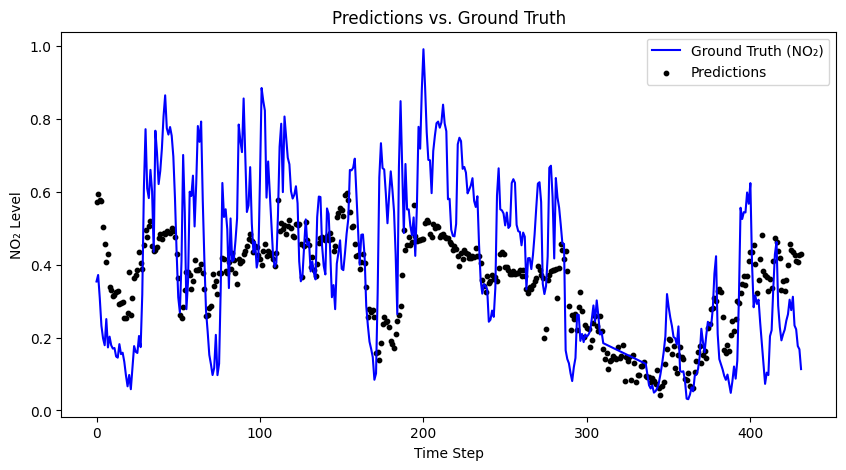

In [39]:
import torch
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
best_model.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch  # Get input and ground truth
        x_test = x_test.to("cpu")  # Ensure data is on CPU if needed

        # Get predictions
        y_pred = best_model(x_test)

        # Store results
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Convert lists to tensors
y_preds = torch.cat(y_preds, dim=0).numpy()
y_trues = torch.cat(y_trues, dim=0).numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title("Predictions vs. Ground Truth")
plt.legend()
plt.show()
